In [31]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns 
import pandas as pd
import matplotlib.ticker as plticker
from matrix_funcs import *
import ternary
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style('ticks') 


# small function that reads generated pipetlog from hamilton
# and maps wells to start and end times
def parse_pipetlog(pipetlog,drop=0):
    df = pd.read_csv(pipetlog,header=0)
    original_wells = df['originalwell'].unique()
    wellsxstartxend = dict()
    for original_well in original_wells:
        df_sub = df[df['originalwell']==original_well][::2]
        times = list(df_sub['time'])
        starts = times[0:-1]
        ends = times[1:]
        startxend = list(zip(starts,ends))
        startxend.append((ends[-1],ends[-1]+14000))
        wellsxstartxend[original_well] = startxend
        
    return wellsxstartxend

# use pipet map to get biotek data time chunks that are relevant for 
# given wells
def extract_traces(dic_pool,df_time,pipet_map,well_request,extend=5):
    wells_dict = {}
    extend=5
    for well in well_request:
        sub_well_list = []
        col_nbr = str(well[1:])
        spl_group = [chr(65+i) + col_nbr for i in range(0,8)]
        well_dil_map = pipet_map[well]

        for i,sub_well in enumerate(spl_group):
            srch_start,srch_end = well_dil_map[i]

            if i!=0:
                start_ind = df_time.sub(srch_start).abs().idxmin()
                end_ind = df_time.sub(srch_end).abs().idxmin()
            else:
                start_ind = 0
                end_ind = df_time.sub(srch_end).abs().idxmin()

            name=sub_well
            ts= df_time[start_ind:end_ind+extend].values/3600
            Ys = dic_pool['YFP'][sub_well].iloc[start_ind:end_ind+extend]
            Ts = dic_pool['mTuq'][sub_well].iloc[start_ind:end_ind+extend]
            sub_well_list.append((name,ts,Ys,Ts))
        wells_dict[well] = sub_well_list
    return wells_dict

# plots log max ratio for several experiments
def plot_log_max_ratio(wells_extracted,previous_ax=None,c_list=None,marker='o'):
    m=9/16
    if previous_ax is None:
        fig,ax = plt.subplots(1,1,figsize=(8*m*0.75,6*m*0.75),dpi=300)
    else:
        ax = previous_ax

        
    for i,well in enumerate(wells_extracted):
        full_y_ax = []
        full_x_ax = []
        for name,ts,Ys,Ts in wells_extracted[well]:
            log_max_ratio= np.log10(np.max((Ys-250)/(10000-250))/np.max((Ts-1300)/(13500-1300)))
            t_ind_max = int(np.round((np.argmax(Ys)+np.argmax(Ts))/2))
            ax.scatter(ts[t_ind_max],log_max_ratio,c=c_list[i],marker=marker,s=30*m)
            full_y_ax.append(log_max_ratio)
            full_x_ax.append(ts[t_ind_max])

        if c_list is None:
            ax.plot(full_x_ax,full_y_ax,label=' ',lw=3*m)

        else:
            ax.plot(full_x_ax,full_y_ax,label=' ',c=c_list[i],lw=3*m)

    if previous_ax is None:
        ax.set_xlabel('Time (hours)',size=17.77*m)
        ax.set_ylabel('Log Ratio YFP:mTurquoise',size=17.77*m,labelpad=10*m)
        ax.tick_params(axis='both', which='major', labelsize=17.77*m)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        return ax
    else:
        return ax

def plot_traces(wells_extracted,mTuq_lim=12000):
    fig,ax = plt.subplots(len(wells_extracted),2,figsize=(7,5))
    for i,well in enumerate(wells_extracted):
        for name,ts,Ys,Ts in wells_extracted[well]:
            ax[i,0].plot(ts,Ys,label=name)
            ax[i,0].set_ylabel('YFP (AU)')
            ax[i,0].set_xlabel('Time (hours)',labelpad=5)
            ax[i,1].plot(ts,Ts,label=name)
            ax[i,1].set_ylabel('mTurquoise (AU)')
            ax[i,1].set_xlabel('Time (hours)',labelpad=5)
            ax[i,0].set_ylim(0,10000)
            ax[i,1].set_ylim(0,mTuq_lim)


        # if i == len(wells_extracted)-1:
        #     ax[i,1].set_xlabel('Time (hours)')

    plt.tight_layout(h_pad=2,w_pad=3)
    return(fig)

# 2D Dataset

## Import

### 0 uM Sal 250 uM IPTG

In [32]:
nts= 252
rows = ['A','B','C','D','E','F','G','H']
cols = ['9','10','11']
spls = [c+r for c,r in product(rows,cols)]
spl_map = dict(zip(spls,spls))
dic_full,df_time = retrieve_dfs('../Source_data/CC/ham_run_p1.csv',[['YFP',70],['mTuq',4114],['OD700',8158]],nts,csv=True)
dic_cut,spl_list = retrieve_samples(dic_full,spls,multi=False)
dic_pool = pool_trips(dic_cut,spl_list,name_map=spl_map,multi=False)
wells_extracted_p1 = extract_traces(dic_pool,df_time,parse_pipetlog('../Source_data/CC/p1_pipetlog.csv',drop=0),well_request=['A9','A10','A11'])


### 4 uM Sal 50 uM IPTG

In [33]:
nts= 252
rows = ['A','B','C','D','E','F','G','H']
cols = ['9','10','11']
spls = [c+r for c,r in product(rows,cols)]
spl_map = dict(zip(spls,spls))
dic_full,df_time = retrieve_dfs('../Source_data/CC/ham_run_p5.csv',[['YFP',70],['mTuq',4114],['OD700',8158]],nts,csv=True)
dic_cut,spl_list = retrieve_samples(dic_full,spls,multi=False)
dic_pool = pool_trips(dic_cut,spl_list,name_map=spl_map,multi=False)
wells_extracted_p5 = extract_traces(dic_pool,df_time,parse_pipetlog('../Source_data/CC/p5_pipetlog.csv',drop=0),well_request=['A9','A10','A11'])

### 4 uM Sal 28 uM IPTG

In [34]:
nts= 252
rows = ['A','B','C','D','E','F','G','H']
cols = ['1','2','3']
spls = [c+r for c,r in product(rows,cols)]
spl_map = dict(zip(spls,spls))
dic_full,df_time = retrieve_dfs('../Source_data/CC/ham_run_0.csv',[['YFP',70],['mTuq',4114],['OD700',8158]],nts,csv=True)
dic_cut,spl_list = retrieve_samples(dic_full,spls,multi=False)
dic_pool = pool_trips(dic_cut,spl_list,name_map=spl_map,multi=False)
wells_extracted_0 = extract_traces(dic_pool,df_time,parse_pipetlog('../Source_data/CC/0_pipetlog.csv',drop=0),well_request=['A1','A2','A3'])


### 4 uM Sal 20 uM IPTG

In [35]:
nts= 252
rows = ['A','B','C','D','E','F','G','H']
cols = ['7','8','9']
spls = [c+r for c,r in product(rows,cols)]
spl_map = dict(zip(spls,spls))
dic_full,df_time = retrieve_dfs('../Source_data/CC/ham_run_m5.csv',[['YFP',70],['mTuq',4114],['OD700',8158]],nts,csv=True)
dic_cut,spl_list = retrieve_samples(dic_full,spls,multi=False)
dic_pool = pool_trips(dic_cut,spl_list,name_map=spl_map,multi=False)
wells_extracted_m5 = extract_traces(dic_pool,df_time,parse_pipetlog('../Source_data/CC/m5_pipetlog.csv',drop=0),well_request=['A7','A8','A9'])

### 4 uM Sal 10 uM IPTG

In [36]:
# minus 1 v2
nts= 252
rows = ['A','B','C','D','E','F','G','H']
cols = ['4','5','6']
spls = [c+r for c,r in product(rows,cols)]
spl_map = dict(zip(spls,spls))
dic_full,df_time = retrieve_dfs('../Source_data/CC/ham_run_m1_V2.csv',[['YFP',70],['mTuq',4114],['OD700',8158]],nts,csv=True)
dic_cut,spl_list = retrieve_samples(dic_full,spls,multi=False)
dic_pool = pool_trips(dic_cut,spl_list,name_map=spl_map,multi=False)
wells_extracted_m1 = extract_traces(dic_pool,df_time,parse_pipetlog('../Source_data/CC/m1_V2_pipetlog.csv',drop=0),well_request=['A4','A5','A6'])

## Plotting

### Main Figures

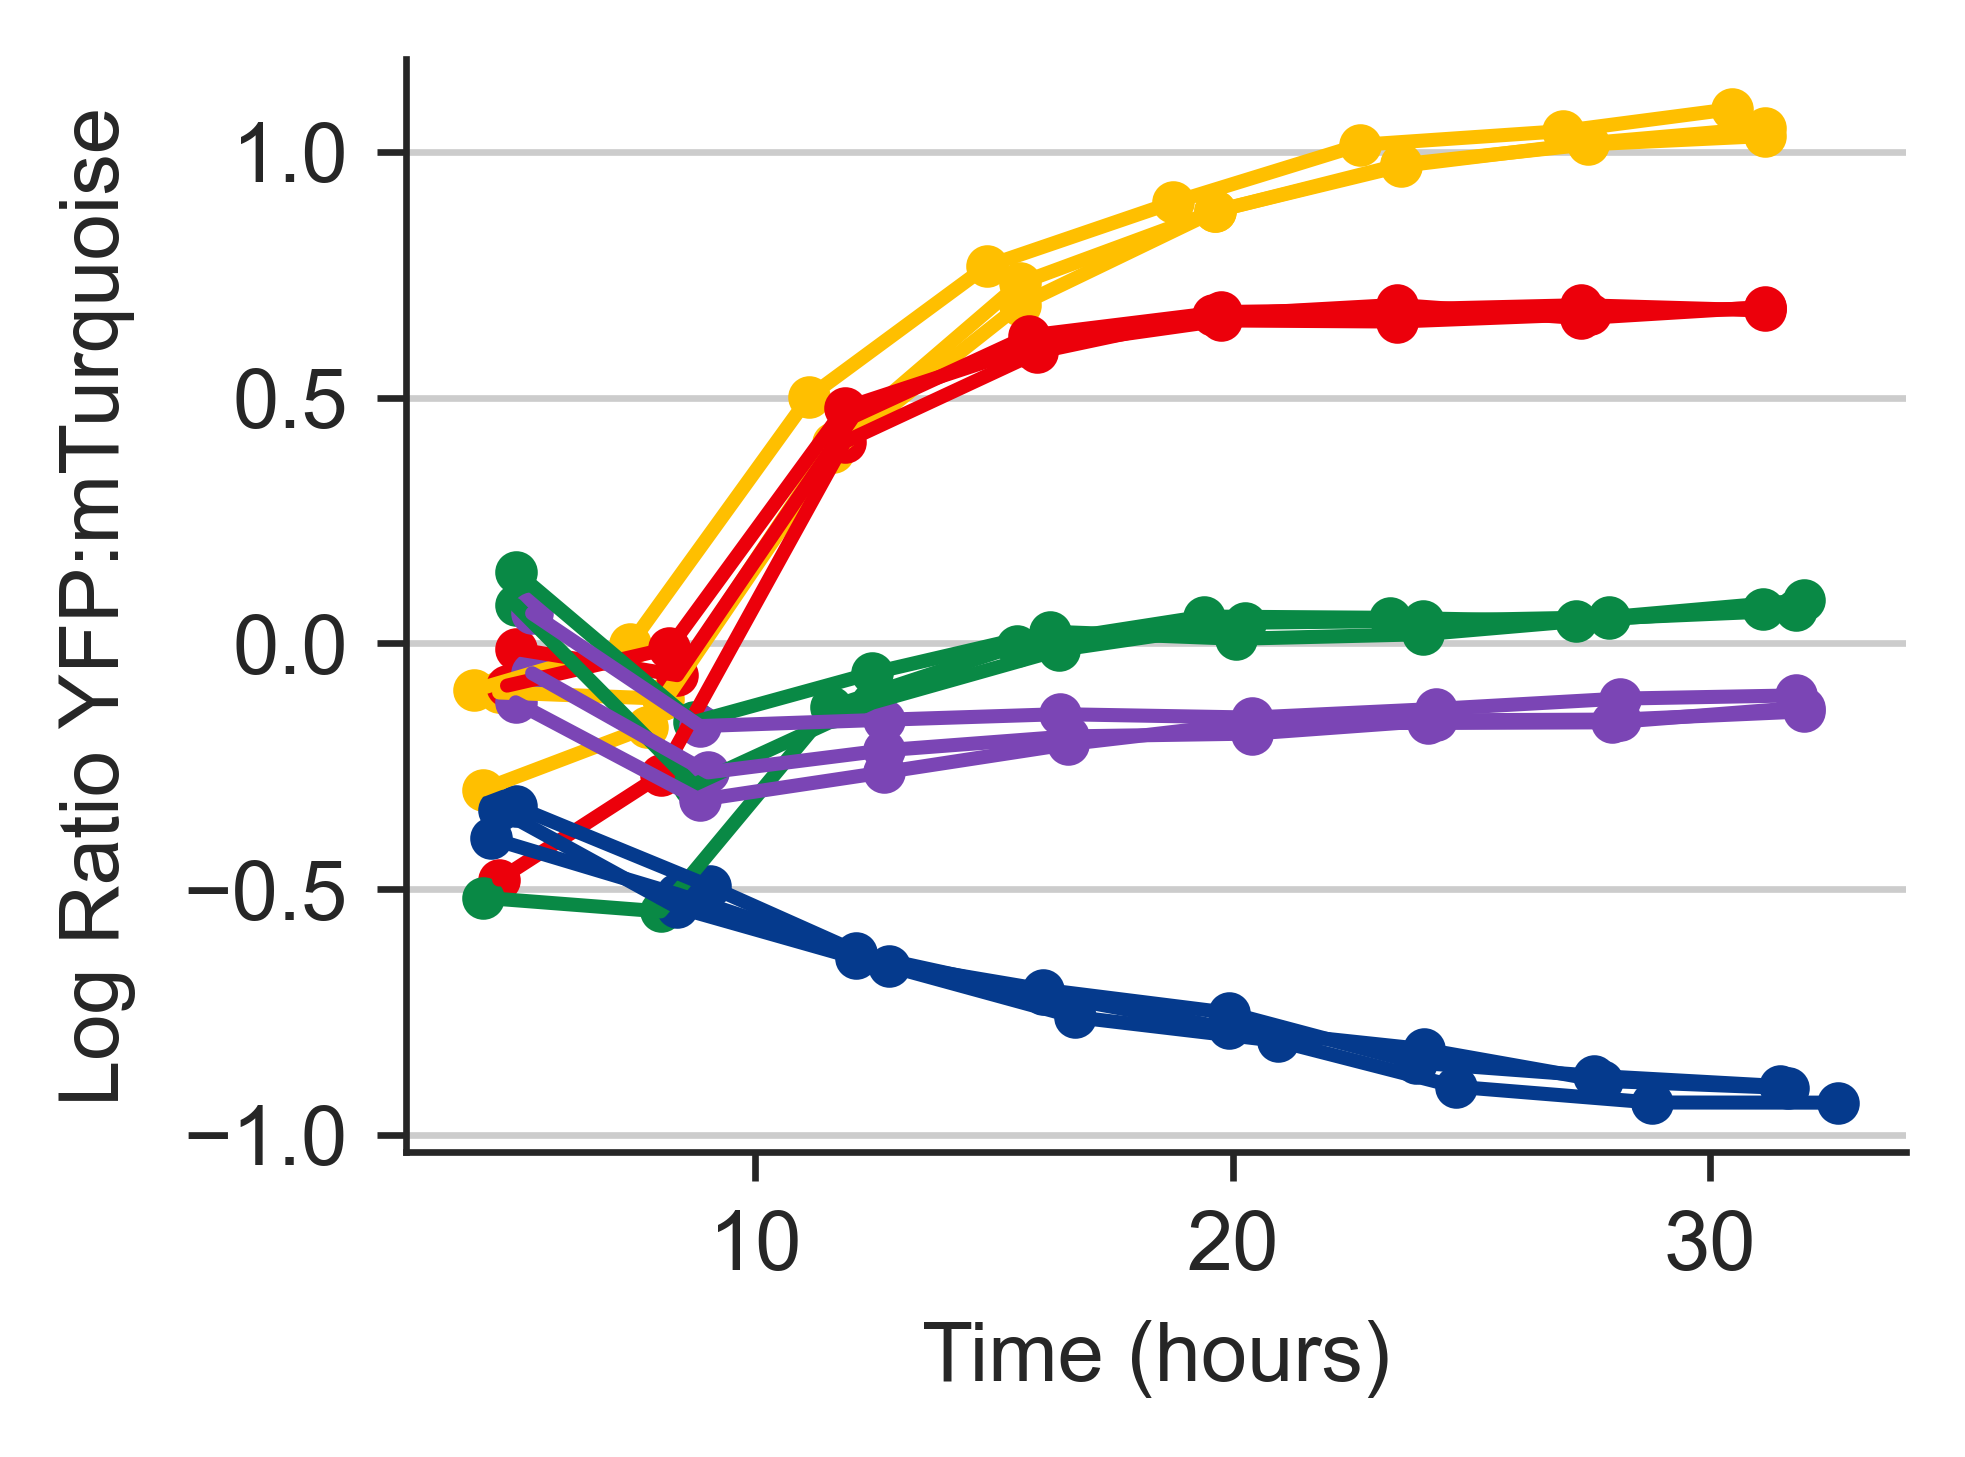

In [37]:
prev_ax = plot_log_max_ratio(wells_extracted_p1,c_list=['#ffbf00','#ffbf00','#ffbf00'])
prev_ax = plot_log_max_ratio(wells_extracted_p5,prev_ax,c_list=['#ec000b','#ec000b','#ec000b'])  
prev_ax = plot_log_max_ratio(wells_extracted_0,prev_ax,c_list=['#098945','#098945','#098945'])
prev_ax = plot_log_max_ratio(wells_extracted_m5,prev_ax,c_list=['#7b45b5','#7b45b5','#7b45b5'])
final_ax = plot_log_max_ratio(wells_extracted_m1,prev_ax,c_list=['#053a8d','#053a8d','#053a8d'])
intervals = 0.5
loc = plticker.MultipleLocator(base=intervals)
final_ax.yaxis.set_major_locator(loc)
final_ax.grid(which='major', axis='y')
final_ax.spines['top'].set_visible(False)
final_ax.spines['right'].set_visible(False)
plt.tight_layout()

### Supplement (Raw Traces)

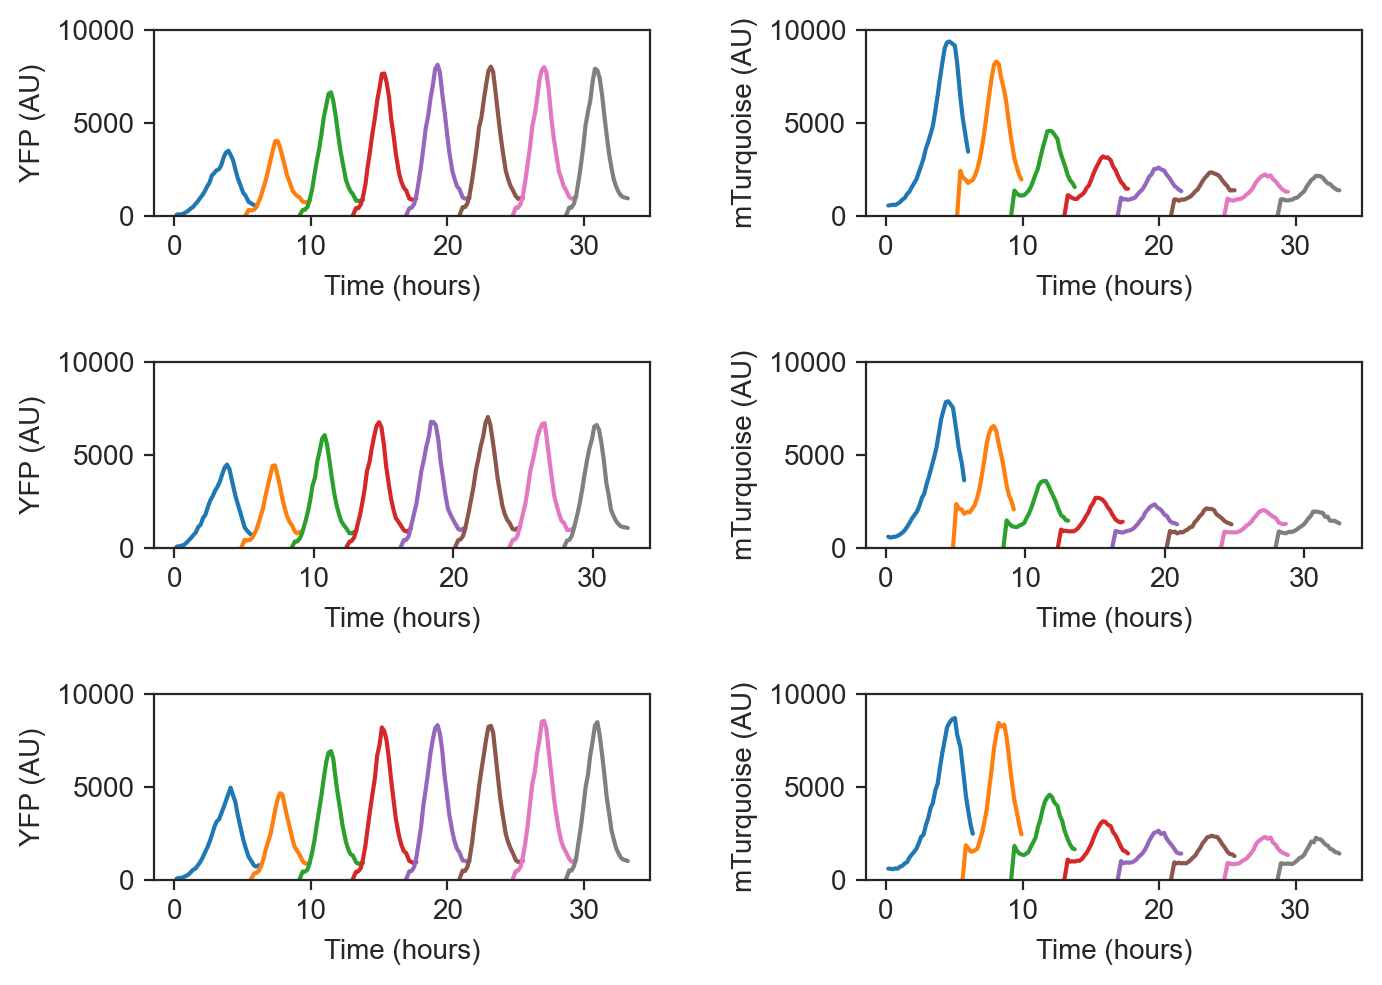

In [38]:
fig = plot_traces(wells_extracted=wells_extracted_p1,mTuq_lim=10000)

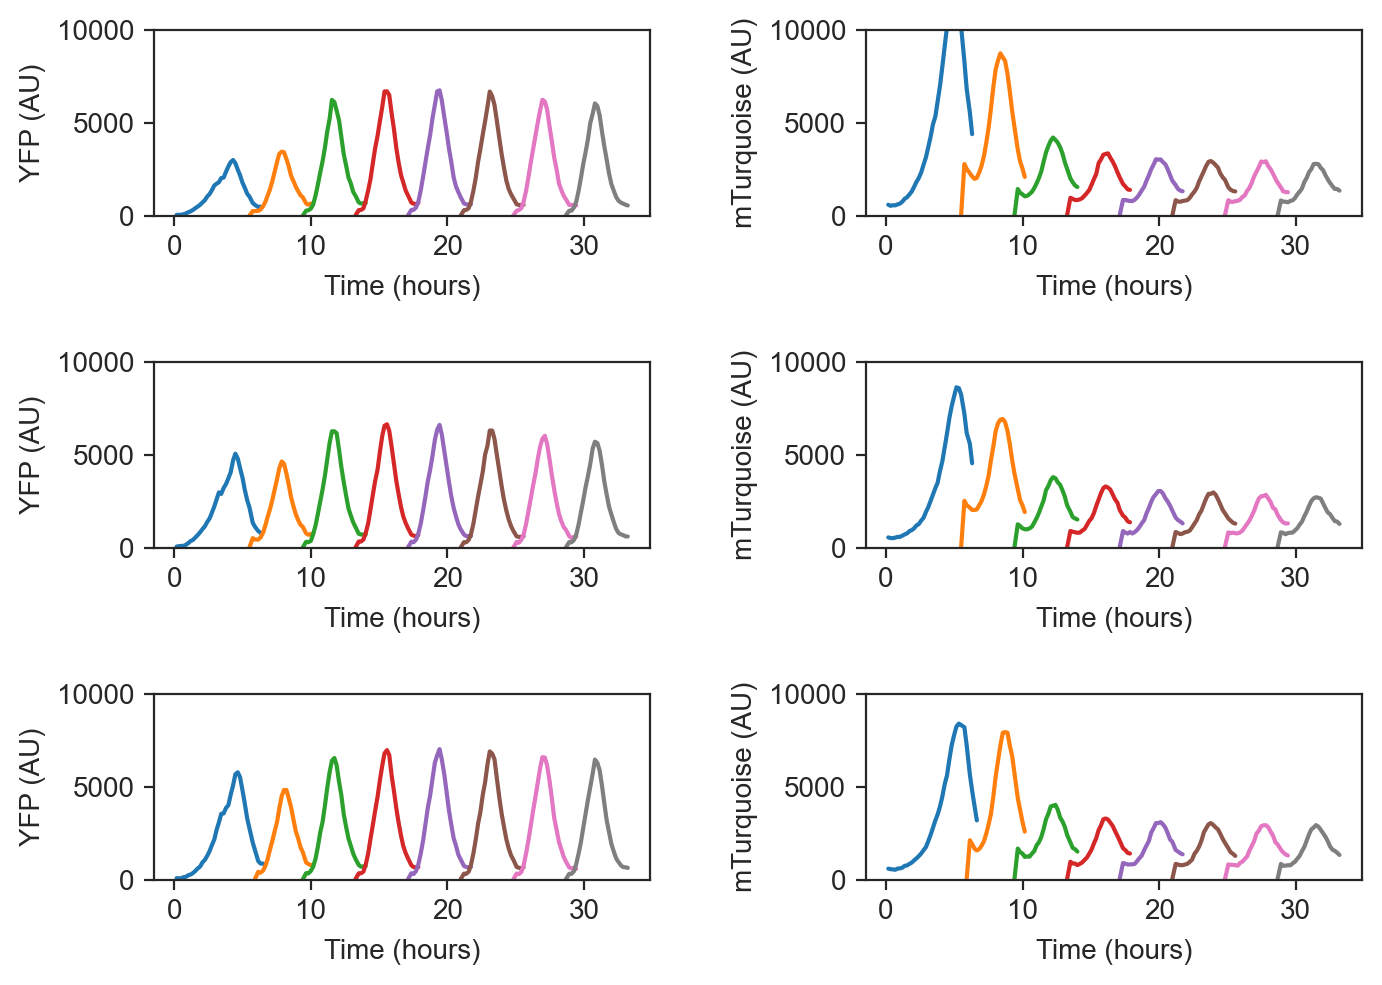

In [42]:
fig = plot_traces(wells_extracted=wells_extracted_p5,mTuq_lim=10000)

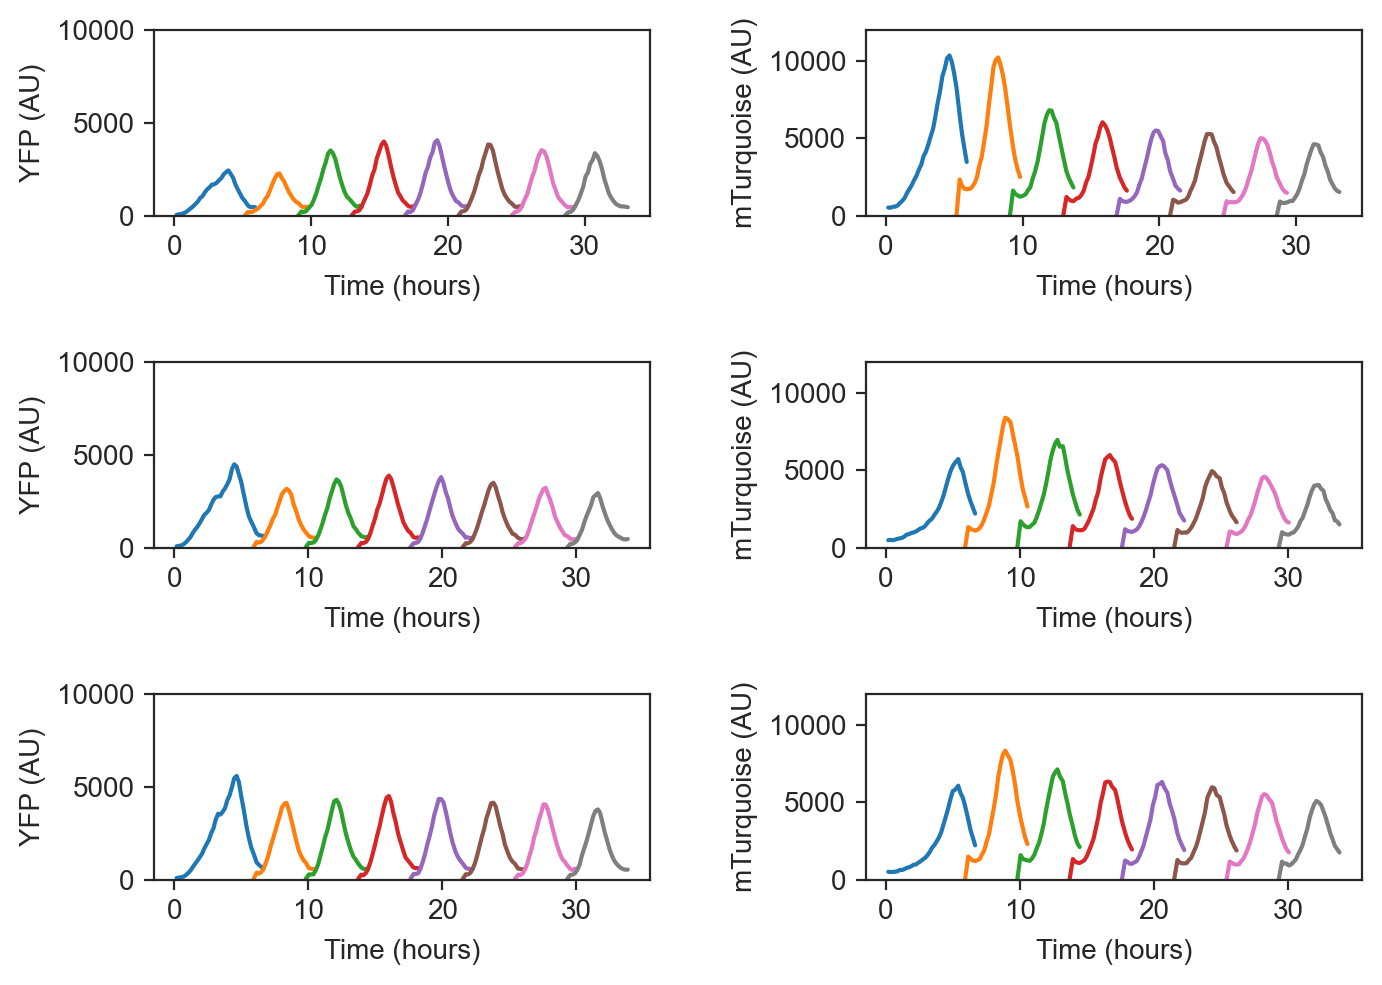

In [43]:
fig=plot_traces(wells_extracted=wells_extracted_0)

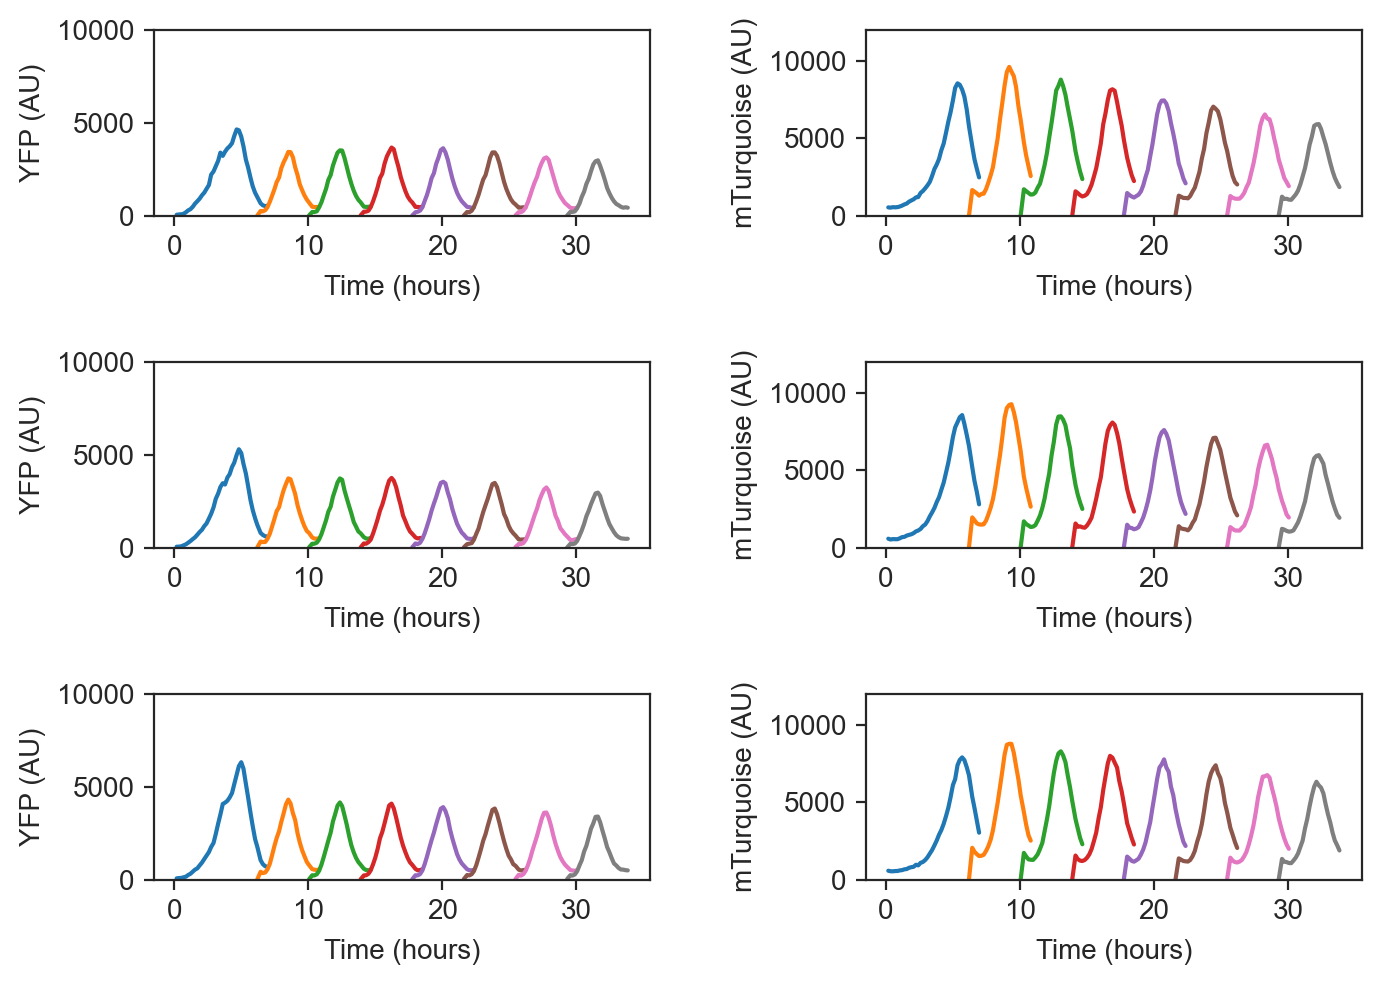

In [44]:
fig=plot_traces(wells_extracted=wells_extracted_m5)

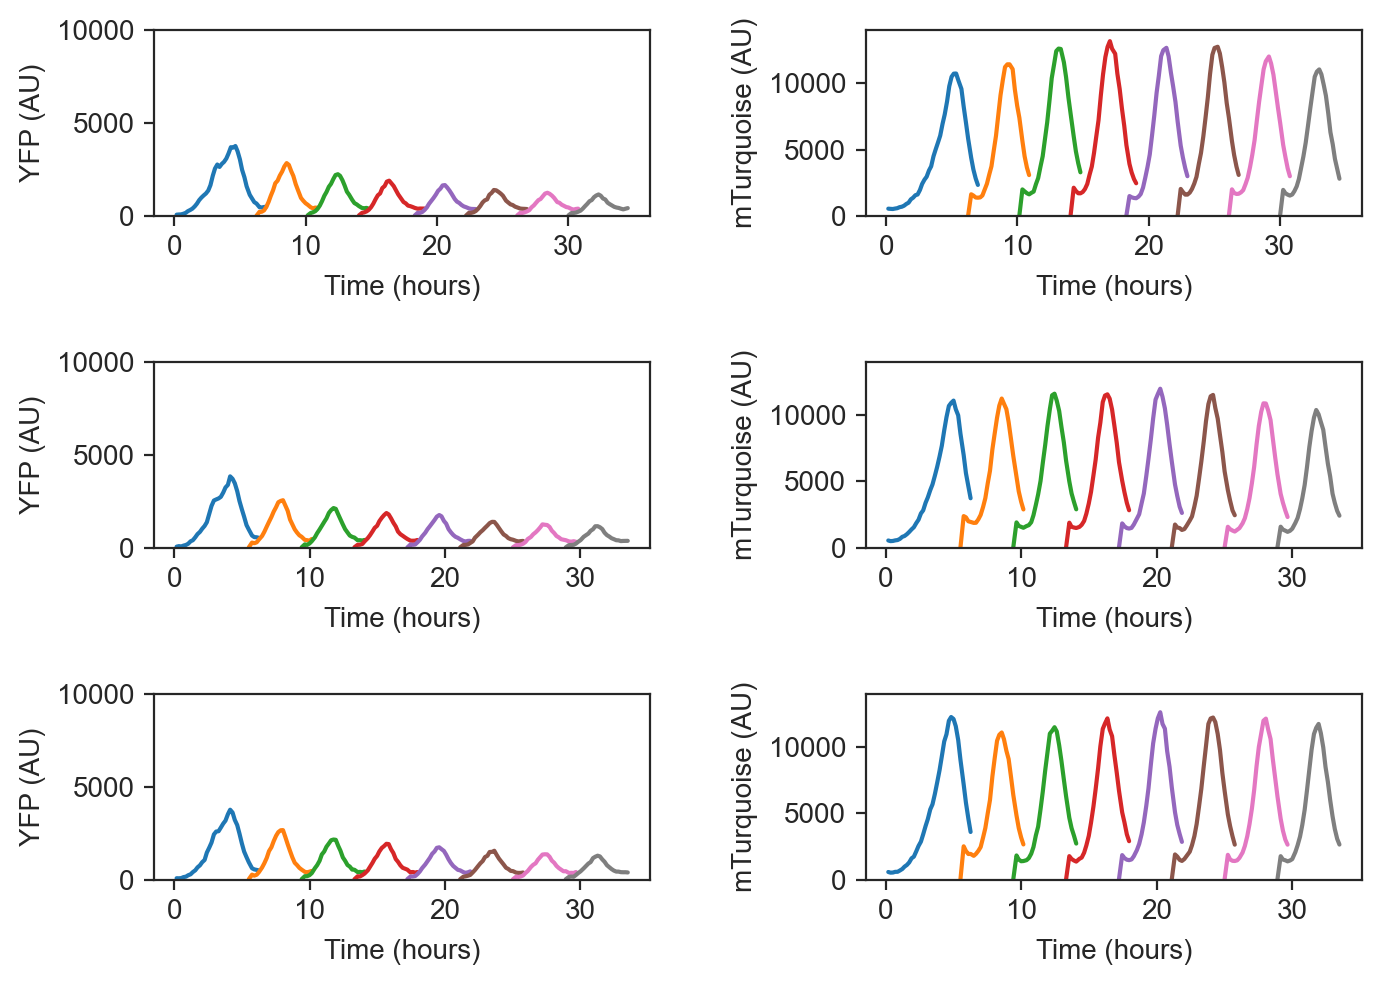

In [45]:
fig=plot_traces(wells_extracted=wells_extracted_m1,mTuq_lim=14000)

# 3D Dataset

In [47]:
def sample_to_traces(dics_list,spl_names,f_name,from_file=True):
    max_arr = np.zeros([len(dics_list),3,len(spl_names)])
    
    if from_file == False:
        for k,cycle in enumerate(dics_list):
            for i,channel in enumerate(['YFP','mTuq','mScarlet']):
                for l,cond in enumerate(spl_names):
                    idx_max = cycle[channel][cond].idxmax()
                    if idx_max < 80:
                        max_arr[k,i,l]= cycle[channel][cond].iloc[idx_max]

                    else:
                        print(f'manual intervention needed at cycle {k+1}, {channel} channel , {cond}')
                        plt.cla()
                        plt.plot(cycle[channel][cond])
                        plt.show()
                        inp = input('Enter max')
                        # if user thinks there is no peak, enter nothing and assign background
                        if inp == '':
                            print('setting to value at t=60')
                            max_arr[k,i,l]= cycle[channel][cond].iloc[60]

                        # if user thinks there is a peak, find it t=40 to 65 range and show it to user
                        else:
                            ex_idx = argrelextrema(cycle[channel][cond][40:65].values, np.greater_equal,order=50)
                            print(cycle[channel][cond].iloc[50+ex_idx[0]])
                            # draw peak
                            if len(ex_idx[0])==1:
                                plt.plot(cycle[channel][cond])
                                plt.hlines(cycle[channel][cond].iloc[40+ex_idx[0]],0,140)
                                plt.show()
                            # edge case where maxima occurs twice... 
                            else:
                                plt.plot(cycle[channel][cond])
                                plt.hlines(cycle[channel][cond].iloc[40+ex_idx[0][0]],0,140)
                                plt.show()

        np.save(f_name,max_arr)


    max_arr = np.load(f_name)
    bg = [700,3800,300]
    mxs = [17000,30000,12000]

    for i in range(0,3):
        val = (max_arr[:,i,:] - bg[i])/mxs[i]
        max_arr[:,i,:] = val

    max_arr = max_arr*[max_arr>0][0]
    max_arr_tern = np.zeros([len(dics_list),3,len(spl_names)])

    for k,cycle in enumerate(dics_list):
        for l,cond in enumerate(spl_names):
            summed = max_arr[k,:,l].sum()
            for i,channel in enumerate(['YFP','mTuq','mScarlet']):
                ch_normed = max_arr[k,i,l]/summed
                max_arr_tern[k,i,l] = ch_normed

    max_arr_tern_w0 = np.zeros([len(dics_list)+1,3,len(spl_names)])
    max_arr_tern_w0[0,:,:] = np.array([[1,]*len(spl_names),[0,]*len(spl_names),[0,]*len(spl_names)])
    max_arr_tern_w0[1:,:,:] = max_arr_tern

    max_arr_tern_pooled = np.zeros([len(dics_list)+1,3,int(len(spl_names)/3)])
    for k in range(0,int(len(dics_list))+1):
        for i,channel in enumerate(['YFP','mTuq','mScarlet']):
            for v in range(0,int(len(spl_names)/3)):
                vals = max_arr_tern_w0[k,i,v*3:(v+1)*3]
                max_arr_tern_pooled[k,i,v] = np.average(vals)

    return max_arr_tern_pooled     

## Importing data

### batch 2

In [48]:
rows = ['E','F','G']
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]
wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_A,wells_config_A]

spl_names = ['Cond4 R1','Cond4 R2','Cond4 R3',
             'Cond5 R1','Cond5 R2','Cond5 R3',
             'Cond6 R1','Cond6 R2','Cond6 R3']


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_A,well_to_name_A]


nts = 120
paths = ['3D_CT_Batch2_C1.xlsx','3D_CT_Batch2_C2.xlsx','3D_CT_Batch2_C3.xlsx','3D_CT_Batch2_C4.xlsx',
         '3D_CT_Batch2_C5.xlsx','3D_CT_Batch2_C6.xlsx','3D_CT_Batch2_C7_V_I.xlsx','3D_CT_Batch2_C8_V_I.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_B2 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_B2.append(dic_pool)

b2_data = sample_to_traces(dics_list_B2,spl_names=spl_names,f_name='../Source_data/CC/npy_files/B2.npy',from_file=True,)

### Batch 4

In [49]:
rows = ['B','E',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_B,wells_config_A,wells_config_B,]

spl_names = ['Cond1_B4 R1','Cond1_B4 R2','Cond1_B4 R3',
             'Cond3_B4 R1','Cond3_B4 R2','Cond3_B4 R3',]


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_B,well_to_name_A,well_to_name_B]


nts = 110
paths = ['3D_CT_Batch4_C1.xlsx','3D_CT_Batch4_C2.xlsx','3D_CT_Batch4_C3.xlsx','3D_CT_Batch4_C4.xlsx',
         '3D_CT_Batch4_C5.xlsx','3D_CT_Batch4_C6.xlsx','3D_CT_Batch4_C7.xlsx',]

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b4 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b4.append(dic_pool)

b4_data = sample_to_traces(dics_list_b4,spl_names=spl_names,f_name='../Source_data/CC/npy_files/B4.npy',from_file=True,)


### batch 5

In [50]:
rows = ['G',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_B,wells_config_A,wells_config_A,
                 wells_config_B,wells_config_B,wells_config_A]

spl_names = ['Cond6_B5 R1','Cond6_B5 R2','Cond6_B5 R3']


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_B,well_to_name_A,well_to_name_A,
            well_to_name_B,well_to_name_B,well_to_name_A,]


nts = 110
paths = ['3D_CT_Batch5_C3_add.xlsx','3D_CT_Batch5_C4.xlsx','3D_CT_Batch5_C5.xlsx','3D_CT_Batch5_C6.xlsx',
         '3D_CT_Batch5_C7.xlsx','3D_CT_Batch5_C8.xlsx','3D_CT_Batch5_C9.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b5 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b5.append(dic_pool)


b5_data = sample_to_traces(dics_list_b5,spl_names=spl_names,f_name='../Source_data/CC/npy_files/B5.npy',from_file=True,)


### batch 6

In [51]:
rows = ['C','D','F',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_B,wells_config_A]

spl_names = ['Cond3_B6 R1','Cond3_B6 R2','Cond3_B6 R3',
             'Cond5_B6 R1','Cond5_B6 R2','Cond5_B6 R3',
             'Cond6_B6 R1','Cond6_B6 R2','Cond6_B6 R3',]


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_B,well_to_name_A]


nts = 110
paths = ['3D_CT_Batch6_C1.xlsx','3D_CT_Batch6_C2.xlsx','3D_CT_Batch6_C3.xlsx','3D_CT_Batch6_C4.xlsx',
         '3D_CT_Batch6_C5.xlsx','3D_CT_Batch6_C6.xlsx','3D_CT_Batch6_C7.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b6 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b6.append(dic_pool)

b6_data = sample_to_traces(dics_list_b6,spl_names=spl_names,f_name='../Source_data/CC/npy_files/B6.npy',from_file=True,)


### batch 7

In [52]:
rows = ['D','E',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]
wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B]

spl_names = ['Cond3_B7 R1','Cond3_B7 R2','Cond3_B7 R3',
             'Cond4_B7 R1','Cond4_B7 R2','Cond4_B7 R3',]


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B]


nts = 110
paths = ['3D_CT_Batch7_C1.xlsx','3D_CT_Batch7_C2.xlsx','3D_CT_Batch7_C3.xlsx','3D_CT_Batch7_C4.xlsx',
         '3D_CT_Batch7_C5.xlsx','3D_CT_Batch7_C6.xlsx','3D_CT_Batch7_C7.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b7 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b7.append(dic_pool)

b7_data = sample_to_traces(dics_list_b7,spl_names=spl_names,f_name='../Source_data/CC/npy_files/B7.npy',from_file=True,)


### batch 10

In [53]:
rows = ['B','C','D','E','F','G',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B,wells_config_B,]

spl_names = ['Cond1_B10 R1','Cond1_B10 R2','Cond1_B10 R3',
             'Cond2_B10 R1','Cond2_B10 R2','Cond2_B10 R3',
             'Cond3_B10 R1','Cond3_B10 R2','Cond3_B10 R3',
             'Cond4_B10 R1','Cond4_B10 R2','Cond4_B10 R3',
             'Cond5_B10 R1','Cond5_B10 R2','Cond5_B10 R3',
             'Cond6_B10 R1','Cond6_B10 R2','Cond6_B10 R3',]

well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,]


nts = 110
paths = ['3D_CT_Batch10_C1.xlsx','3D_CT_Batch10_C2.xlsx','3D_CT_Batch10_C3.xlsx','3D_CT_Batch10_C4.xlsx',
         '3D_CT_Batch10_C5.xlsx','3D_CT_Batch10_C6.xlsx','3D_CT_Batch10_C7.xlsx','3D_CT_Batch10_C8.xlsx',
         '3D_CT_Batch10_C9.xlsx','3D_CT_Batch10_C10.xlsx',]

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b10 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b10.append(dic_pool)

b10_data = sample_to_traces(dics_list_b10,spl_names=spl_names,f_name='../Source_data/CC/npy_files/B10.npy',from_file=True,)

## Plotting main figure

### 3-state, long-term stable (Fig 6d)

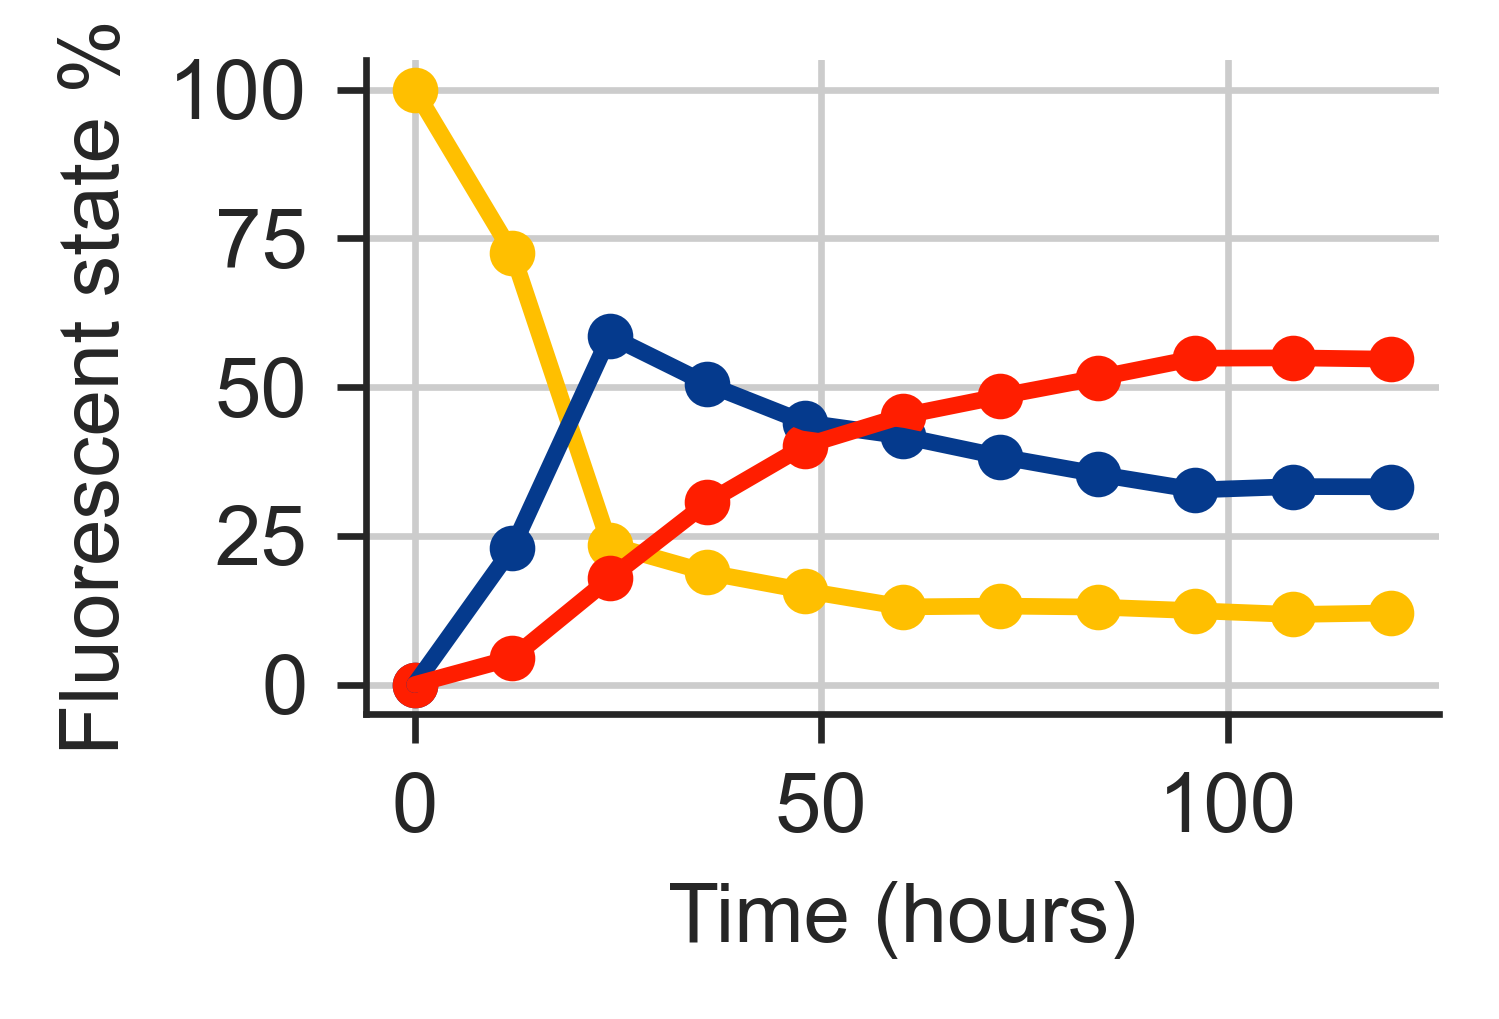

In [54]:
matplotlib.rcParams['figure.figsize'] = (2.6, 1.8)
fig,ax=plt.subplots(1,1,dpi=300)

ts = np.array([0,1,2,3,
      4,5,6,7,
      8,9,10])*12

idx=5

plt.scatter(ts,b10_data[:,0,idx]*100,marker='o',s=20,c='#ffbf00')
plt.scatter(ts,b10_data[:,1,idx]*100,marker='o',s=20,c='#053a8d')
plt.scatter(ts,b10_data[:,2,idx]*100,marker='o',s=20,c='#FF1E00')
plt.plot(ts,b10_data[:,0,idx]*100,c='#ffbf00',label='YFP',lw=2)
plt.plot(ts,b10_data[:,1,idx]*100,c='#053a8d',label='mTurquoise',lw=2)
plt.plot(ts,b10_data[:,2,idx]*100,c='#FF1E00',label='mScarlet',lw=2)
plt.yticks([0,25,50,75,100])

ax.set_xlabel('Time (hours)',size=10)
ax.set_ylabel('Fluorescent state %',size=10,)
ax.tick_params(axis='both', which='major', labelsize=10)
# ax.legend(fontsize=9,ncols=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

intervals = 25
loc = plticker.MultipleLocator(base=intervals)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='both')
plt.tight_layout()

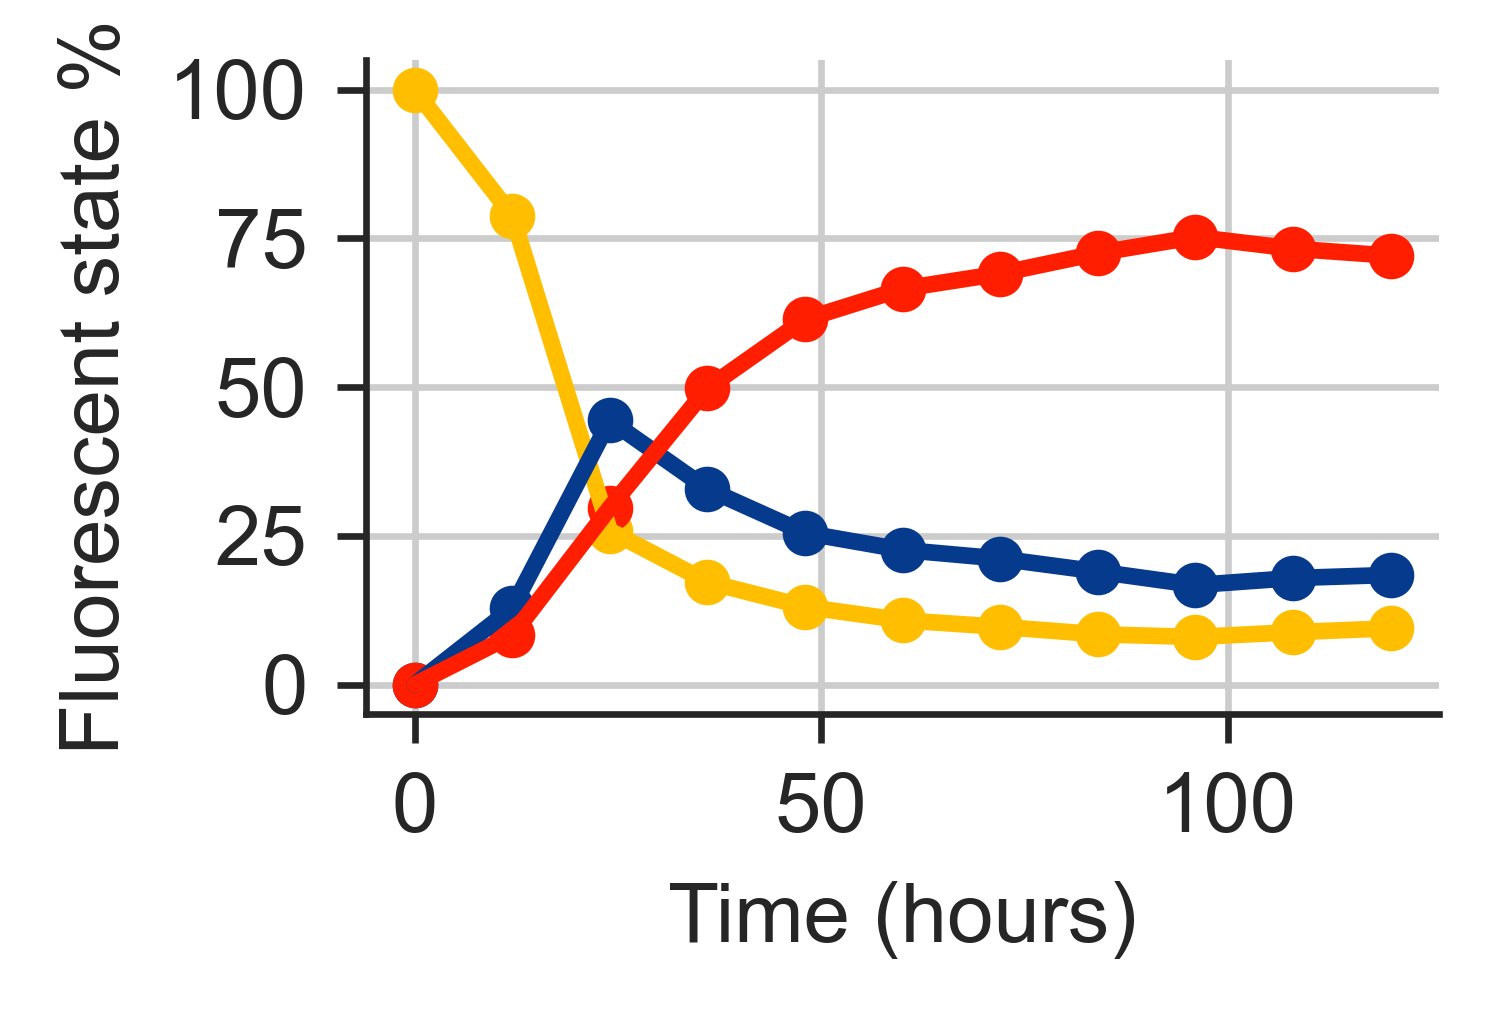

In [55]:
matplotlib.rcParams['figure.figsize'] = (2.6, 1.8)
fig,ax=plt.subplots(1,1,dpi=300)

ts = np.array([0,1,2,3,
      4,5,6,7,
      8,9,10])*12

idx=3

plt.scatter(ts,b10_data[:,0,idx]*100,marker='o',s=20,c='#ffbf00')
plt.scatter(ts,b10_data[:,1,idx]*100,marker='o',s=20,c='#053a8d')
plt.scatter(ts,b10_data[:,2,idx]*100,marker='o',s=20,c='#FF1E00')
plt.plot(ts,b10_data[:,0,idx]*100,c='#ffbf00',label='YFP',lw=2)
plt.plot(ts,b10_data[:,1,idx]*100,c='#053a8d',label='mTurquoise',lw=2)
plt.plot(ts,b10_data[:,2,idx]*100,c='#FF1E00',label='mScarlet',lw=2)
plt.yticks([0,25,50,75,100])

ax.set_xlabel('Time (hours)',size=10)
ax.set_ylabel('Fluorescent state %',size=10,)
ax.tick_params(axis='both', which='major', labelsize=10)
# ax.legend(fontsize=9,ncols=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

intervals = 25
loc = plticker.MultipleLocator(base=intervals)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='both')
plt.tight_layout()

### Ternary diagram (Fig 6e)

/Users/mfk/anaconda3/envs/data_anal/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


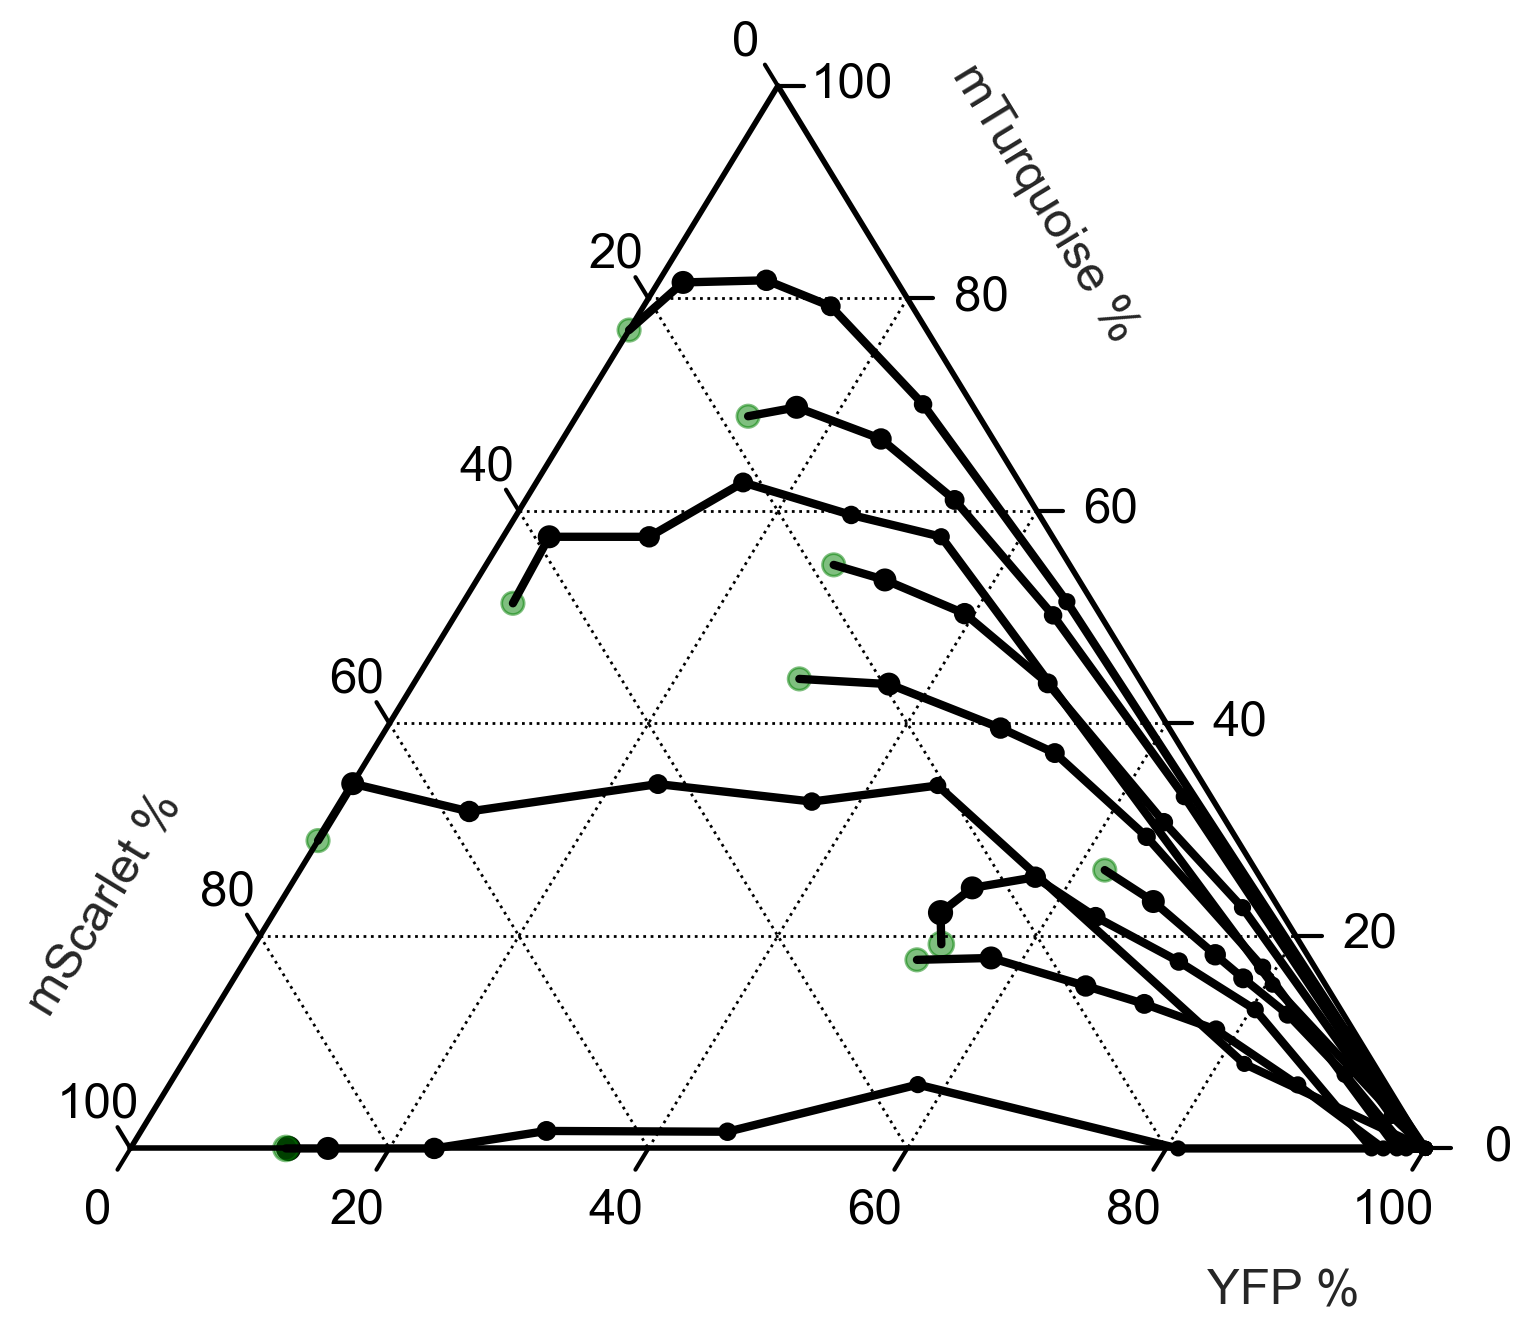

In [56]:
m=0.95
matplotlib.rcParams['figure.figsize'] = (8*m, 6.92*m)
from matplotlib.patches import Polygon


figure, tax = ternary.figure(scale=100)
tax.gridlines(multiple=20, color="black",lw=1)
tax.boundary(linewidth=2)

a=1
cs = ['black' for i in range(0,20)]
marker_csA =['k','k','k','k','k','k','k','k','green']
marker_csB =['k','k','k','k','k','k','k','green']
alphas_A = [1,1,1,1,1,1,1,1,0.5]
alphas_B = [1,1,1,1,1,1,1,0.5]
ss = [20,23,27,32,38,45,53,65,80]


pooled_list = [b2_data,b4_data,b5_data,b6_data,b7_data]
idx_list = [(0,1),(0,1),(0,),(0,1,2),(0,1)]



count=1
for i,idx_set in enumerate(idx_list):
    for idx in idx_set:
        if i == 0:
            tax.plot(pooled_list[i][:,:,idx]*100,lw=3,alpha=a,c='k')
            tax.scatter(pooled_list[i][:,:,idx]*100,s=ss,c=marker_csA,alpha=alphas_A)
        else:
            tax.plot(pooled_list[i][:,:,idx]*100,lw=3,alpha=a,c='k')
            tax.scatter(pooled_list[i][:,:,idx]*100,s=ss[0:-1],c=marker_csB,alpha=alphas_B)

        count+=1


tax.ticks(axis='lbr',multiple=20, fontsize=17.77,offset=0.02)
tax.get_axes().axis('off')
tax.left_axis_label("mScarlet %", fontsize=17.77, offset=0.14,position=(-0.135,0.34))
tax.right_axis_label("mTurquoise %", fontsize=17.77, offset=0.14,position=(0.18,1))
tax.bottom_axis_label("YFP %", fontsize=17.77, offset=0,position=(0.87,-0.03))
tax.set_background_color(color='none')
plt.tight_layout()

### Supplement alternative version

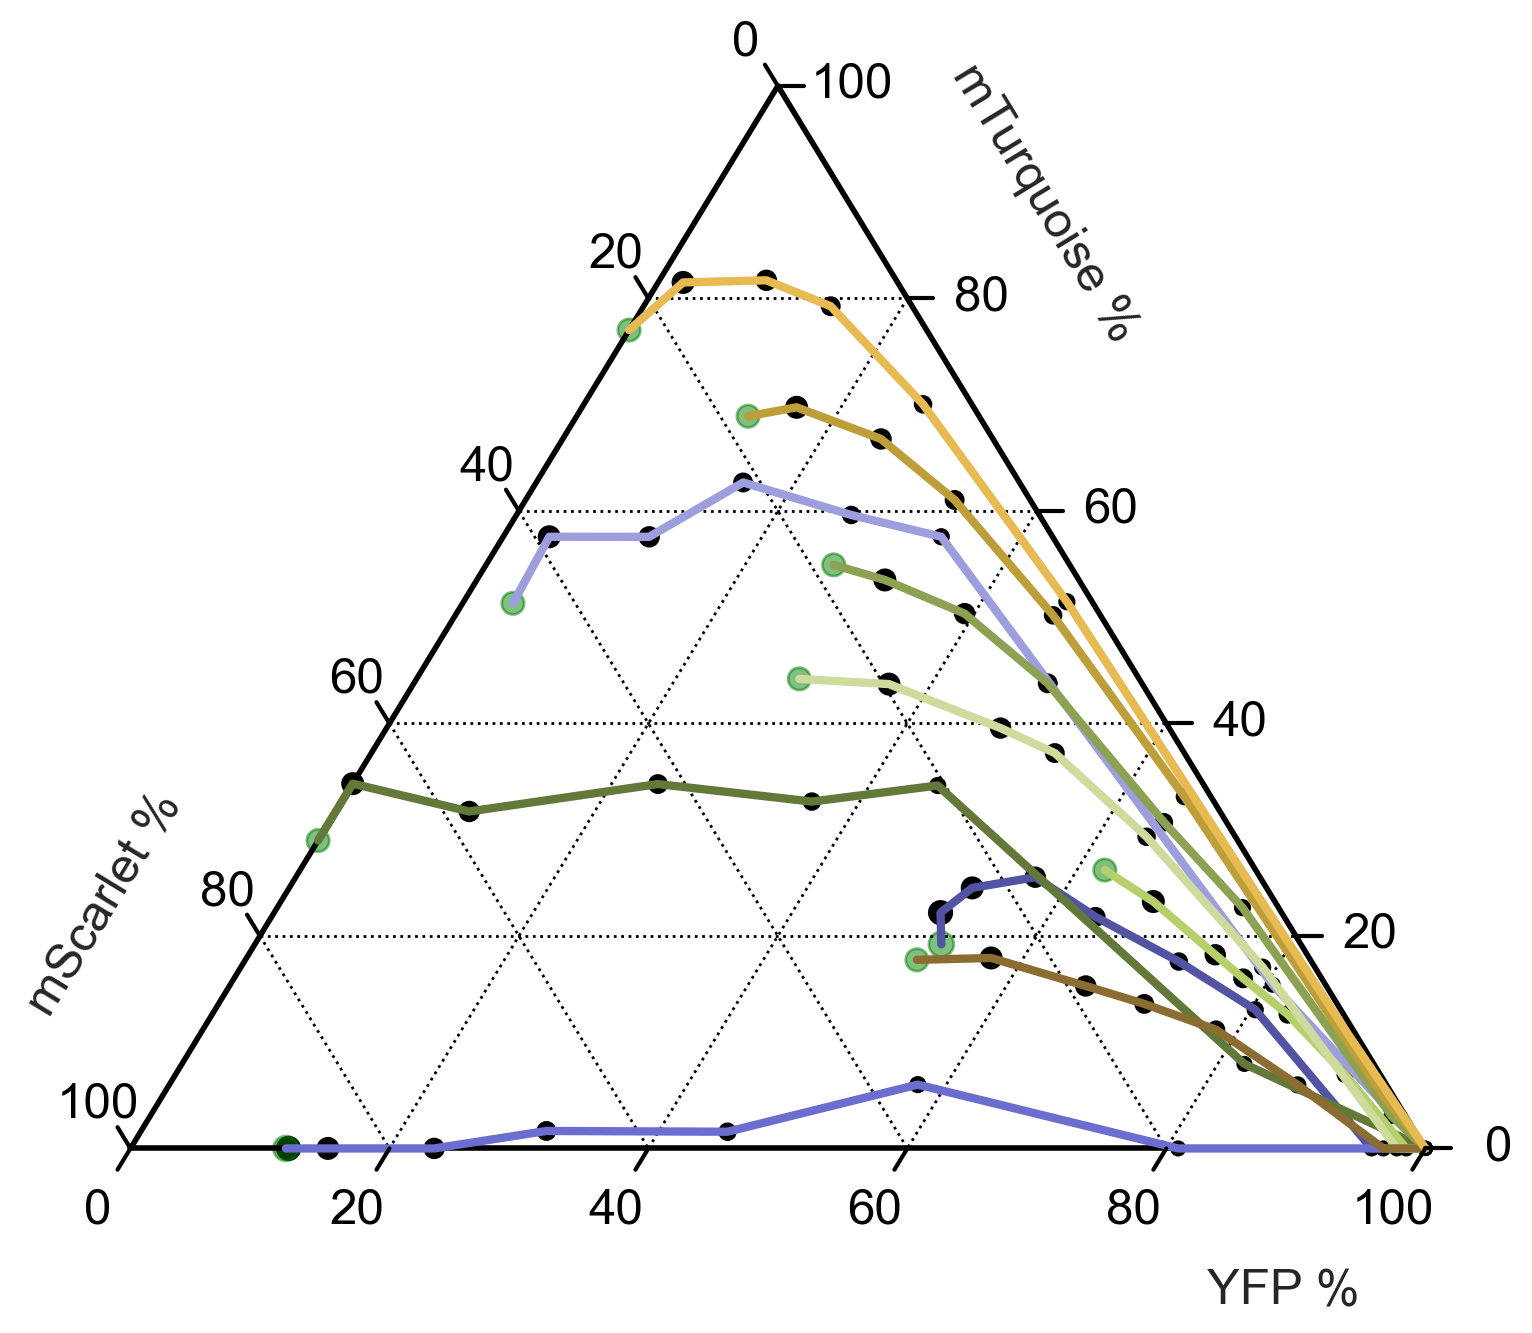

In [57]:
m=0.95
matplotlib.rcParams['figure.figsize'] = (8*m, 6.92*m)
from matplotlib.patches import Polygon


figure, tax = ternary.figure(scale=100)
tax.gridlines(multiple=20, color="black",lw=1)
tax.boundary(linewidth=2)

a=1
cmap = plt.cm.tab20b
cs = [cmap(i) for i in range(0,cmap.N,1)]
marker_csA =['k','k','k','k','k','k','k','k','green']
marker_csB =['k','k','k','k','k','k','k','green']
alphas_A = [1,1,1,1,1,1,1,1,0.5]
alphas_B = [1,1,1,1,1,1,1,0.5]
ss = [20,23,27,32,38,45,53,65,80]


pooled_list = [b2_data,b4_data,b5_data,b6_data,b7_data]
idx_list = [(0,1),(0,1),(0,),(0,1,2),(0,1)]



count=1
for i,idx_set in enumerate(idx_list):
    for idx in idx_set:
        if i == 0:
            tax.plot(pooled_list[i][:,:,idx]*100,lw=3,alpha=a,c=cs[count])
            tax.scatter(pooled_list[i][:,:,idx]*100,s=ss,c=marker_csA,alpha=alphas_A)
        else:
            tax.plot(pooled_list[i][:,:,idx]*100,lw=3,alpha=a,c=cs[count])
            tax.scatter(pooled_list[i][:,:,idx]*100,s=ss[0:-1],c=marker_csB,alpha=alphas_B)

        count+=1


tax.ticks(axis='lbr',multiple=20, fontsize=17.77,offset=0.02)
tax.get_axes().axis('off')
tax.left_axis_label("mScarlet %", fontsize=17.77, offset=0.14,position=(-0.135,0.34))
tax.right_axis_label("mTurquoise %", fontsize=17.77, offset=0.14,position=(0.18,1))
tax.bottom_axis_label("YFP %", fontsize=17.77, offset=0,position=(0.87,-0.03))
tax.set_background_color(color='none')
plt.tight_layout()

## Plotting Supplement Raw Traces

In [58]:
cmap = plt.cm.viridis
cs = [cmap(i) for i in range(0,cmap.N,35)]

### Batch 2 (A,B)

In [59]:
rows = ['E','F',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]
wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_A,wells_config_A]

spl_names = ['Cond4 R1','Cond4 R2','Cond4 R3',
             'Cond5 R1','Cond5 R2','Cond5 R3',
             'Cond6 R1','Cond6 R2','Cond6 R3']


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_A,well_to_name_A]


nts = 120
paths = ['3D_CT_Batch2_C1.xlsx','3D_CT_Batch2_C2.xlsx','3D_CT_Batch2_C3.xlsx','3D_CT_Batch2_C4.xlsx',
         '3D_CT_Batch2_C5.xlsx','3D_CT_Batch2_C6.xlsx','3D_CT_Batch2_C7_V_I.xlsx','3D_CT_Batch2_C8_V_I.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_B2 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_B2.append(dic_pool)



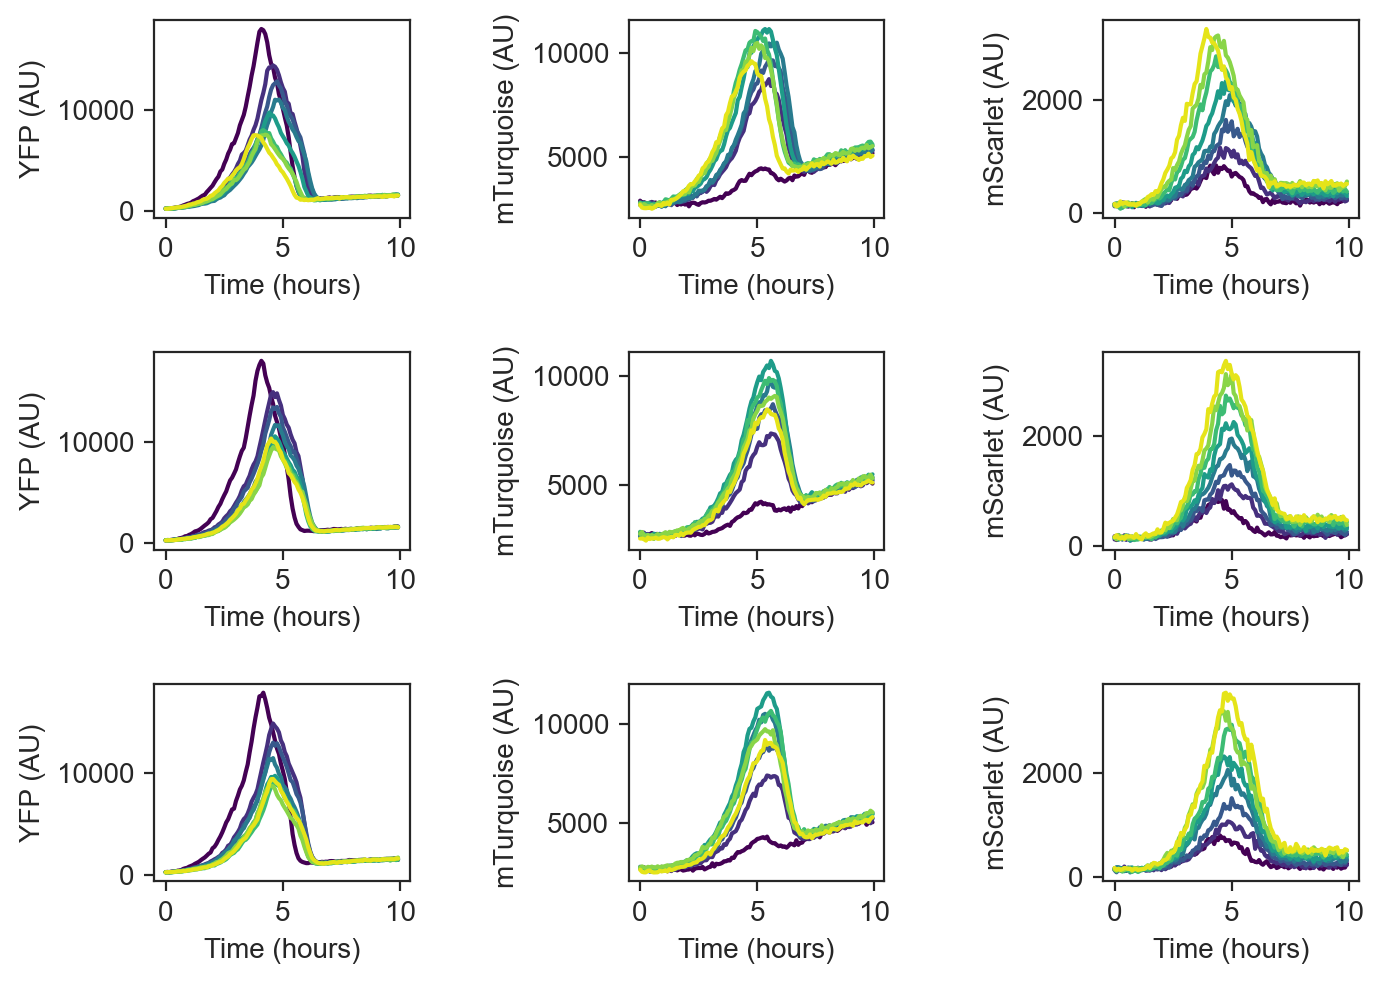

In [60]:
spl_idxs = [list(range(0,3)),list(range(3,6)),]
ts = np.arange(0,len(dics_list_B2[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_B2):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

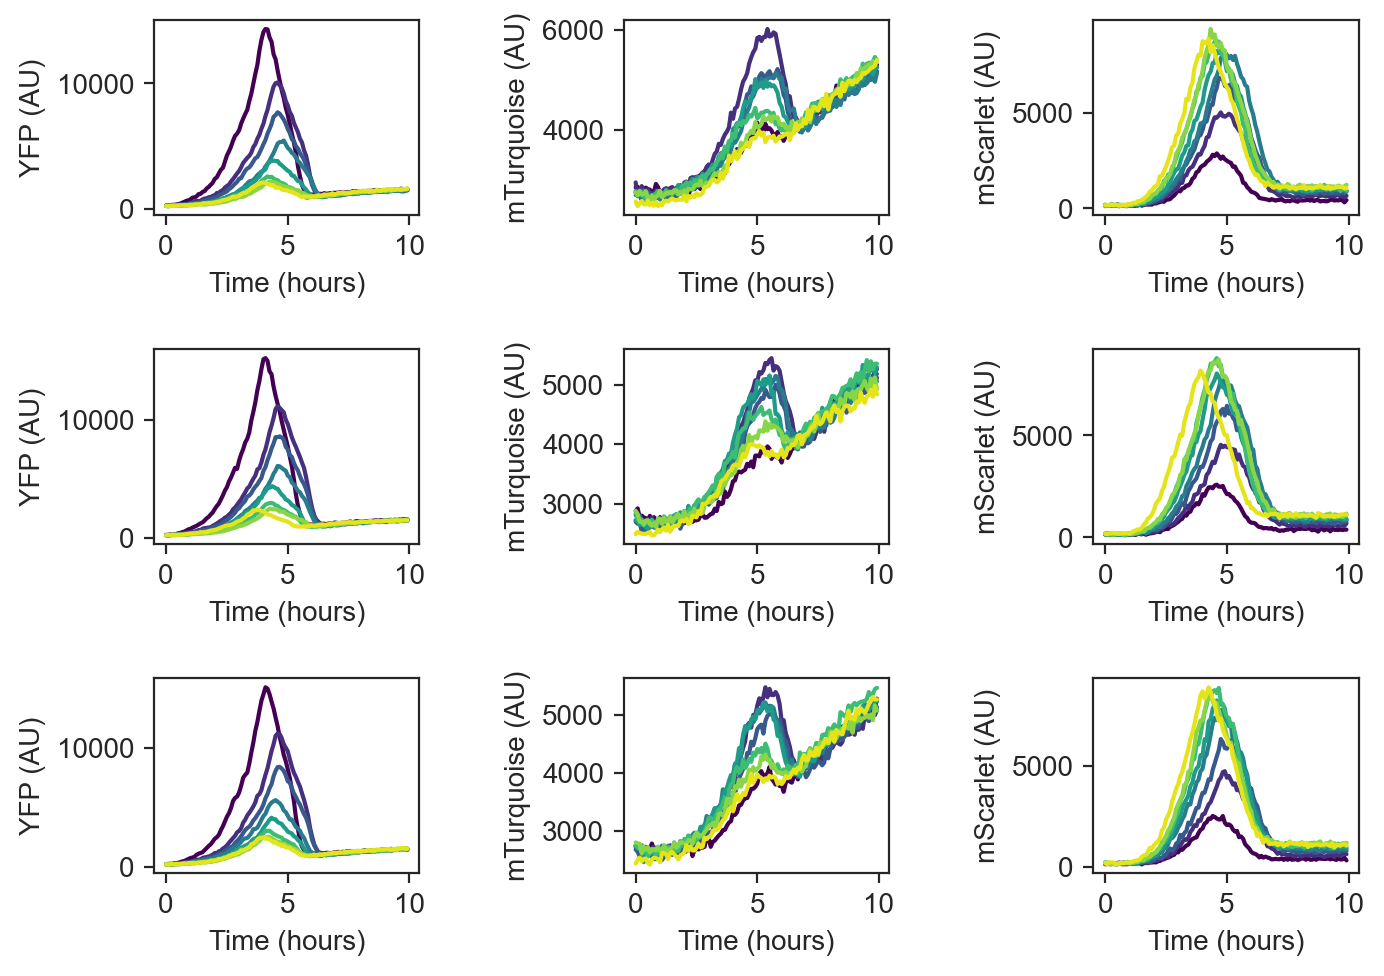

In [61]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[1]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_B2):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

### Batch 4 (C,D)

In [62]:
rows = ['B','E',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_B,wells_config_A,wells_config_B,]

spl_names = ['Cond1_B4 R1','Cond1_B4 R2','Cond1_B4 R3',
             'Cond3_B4 R1','Cond3_B4 R2','Cond3_B4 R3',
             'Cond4_B4 R1','Cond4_B4 R2','Cond4_B4 R3',]


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_B,well_to_name_A,well_to_name_B]


nts = 110
paths = ['3D_CT_Batch4_C1.xlsx','3D_CT_Batch4_C2.xlsx','3D_CT_Batch4_C3.xlsx','3D_CT_Batch4_C4.xlsx',
         '3D_CT_Batch4_C5.xlsx','3D_CT_Batch4_C6.xlsx','3D_CT_Batch4_C7.xlsx',]

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b4 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b4.append(dic_pool)

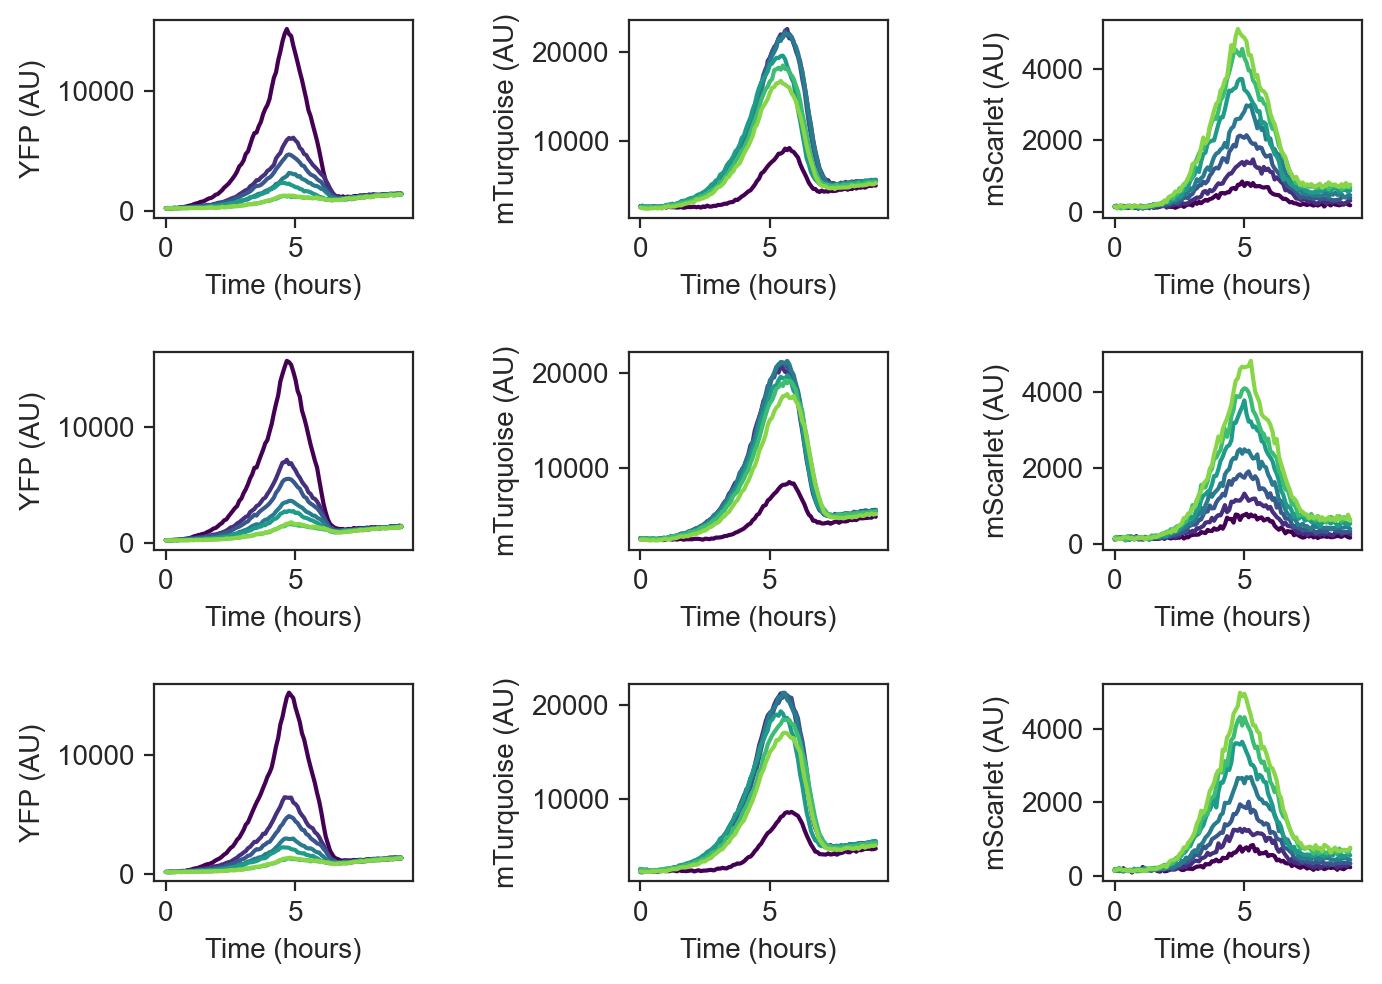

In [63]:
spl_idxs = [list(range(0,3)),list(range(3,6)),]
ts = np.arange(0,len(dics_list_b4[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b4):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

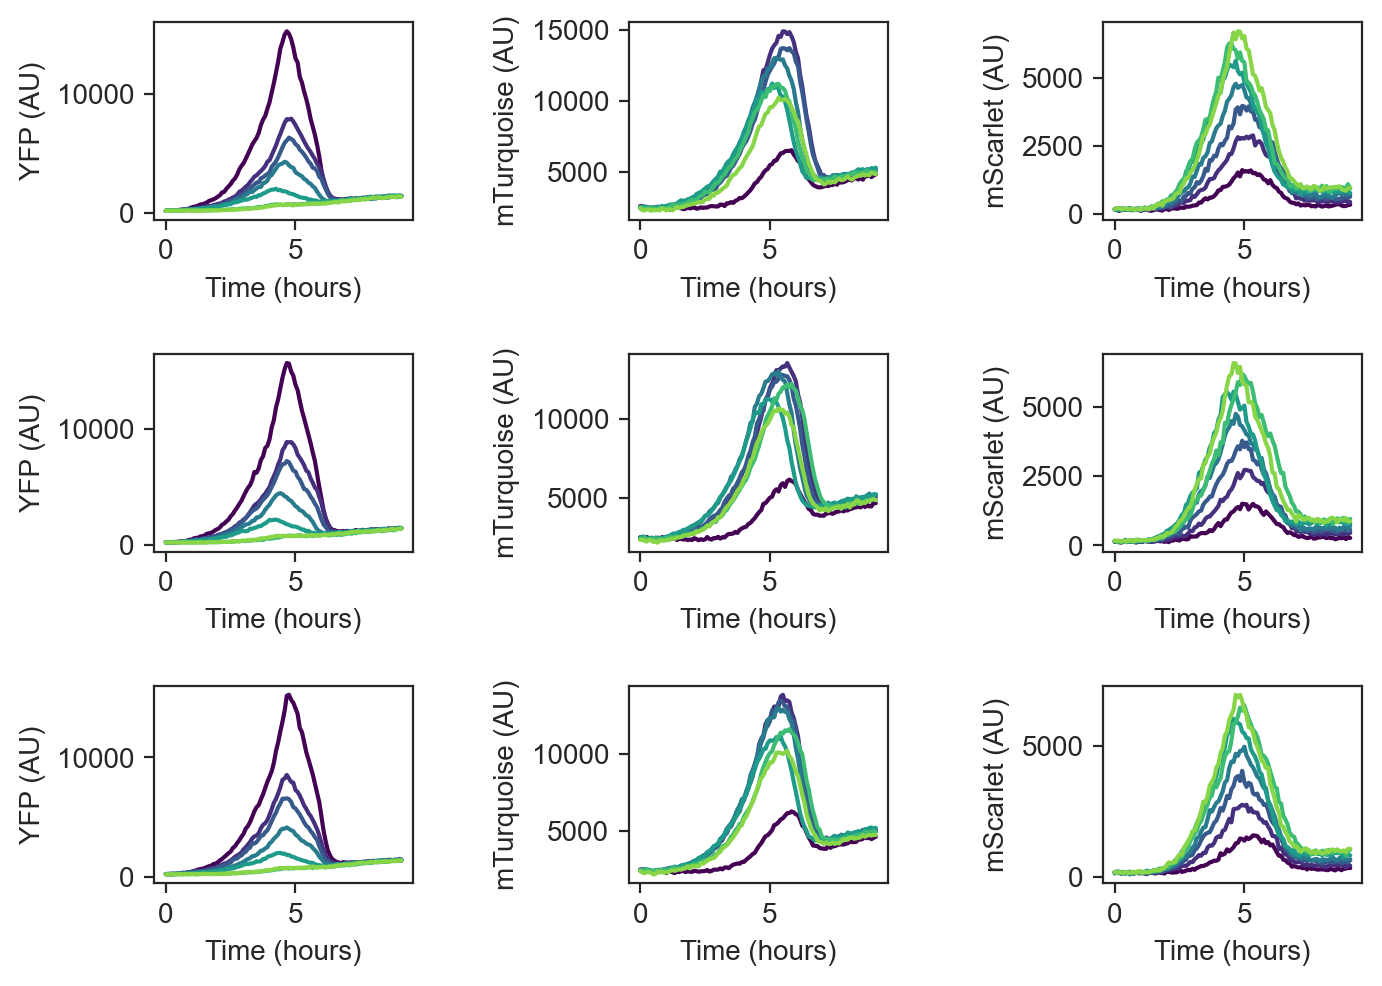

In [64]:
ts = np.arange(0,len(dics_list_b4[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[1]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b4):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

### Batch 5 (E)

In [65]:
rows = ['G',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_B,wells_config_A,wells_config_A,
                 wells_config_B,wells_config_B,wells_config_A]

spl_names = ['Cond6_B5 R1','Cond6_B5 R2','Cond6_B5 R3']


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_B,well_to_name_A,well_to_name_A,
            well_to_name_B,well_to_name_B,well_to_name_A,]


nts = 110
paths = ['3D_CT_Batch5_C3_add.xlsx','3D_CT_Batch5_C4.xlsx','3D_CT_Batch5_C5.xlsx','3D_CT_Batch5_C6.xlsx',
         '3D_CT_Batch5_C7.xlsx','3D_CT_Batch5_C8.xlsx','3D_CT_Batch5_C9.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b5 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b5.append(dic_pool)

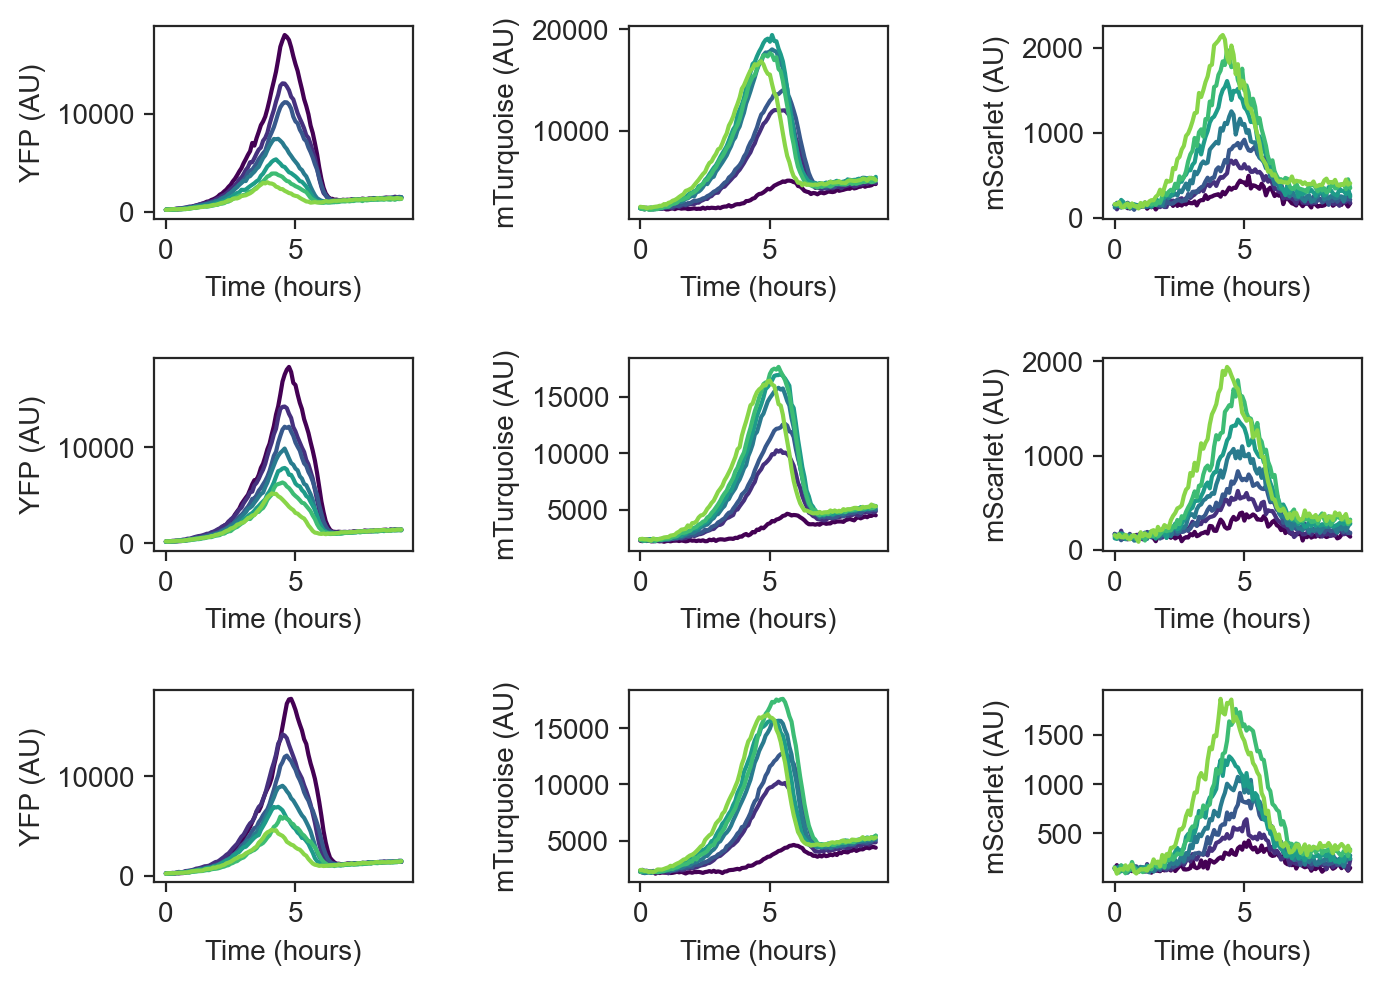

In [66]:
spl_idxs = [list(range(0,3)),]
ts = np.arange(0,len(dics_list_b5[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b5):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

### Batch 6 (F,G,H)

In [67]:
rows = ['C','D','F',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_B,wells_config_A]

spl_names = ['Cond3_B6 R1','Cond3_B6 R2','Cond3_B6 R3',
             'Cond5_B6 R1','Cond5_B6 R2','Cond5_B6 R3',
             'Cond6_B6 R1','Cond6_B6 R2','Cond6_B6 R3',]


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_B,well_to_name_A]


nts = 110
paths = ['3D_CT_Batch6_C1.xlsx','3D_CT_Batch6_C2.xlsx','3D_CT_Batch6_C3.xlsx','3D_CT_Batch6_C4.xlsx',
         '3D_CT_Batch6_C5.xlsx','3D_CT_Batch6_C6.xlsx','3D_CT_Batch6_C7.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b6 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b6.append(dic_pool)

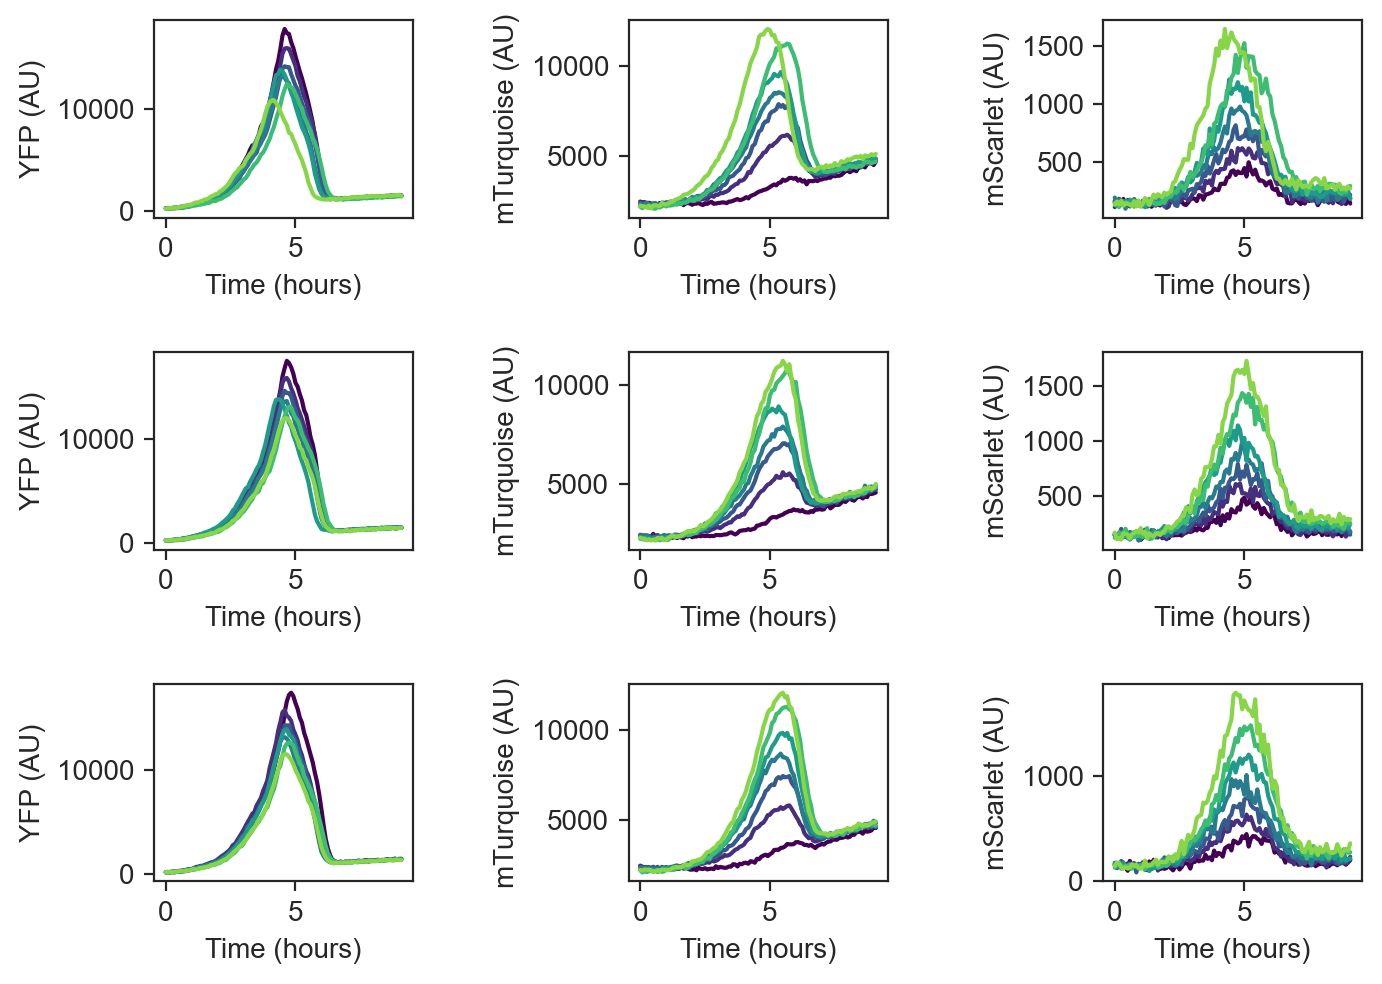

In [68]:
spl_idxs = [list(range(0,3)),list(range(3,6)),list(range(6,9))]
ts = np.arange(0,len(dics_list_b6[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b6):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

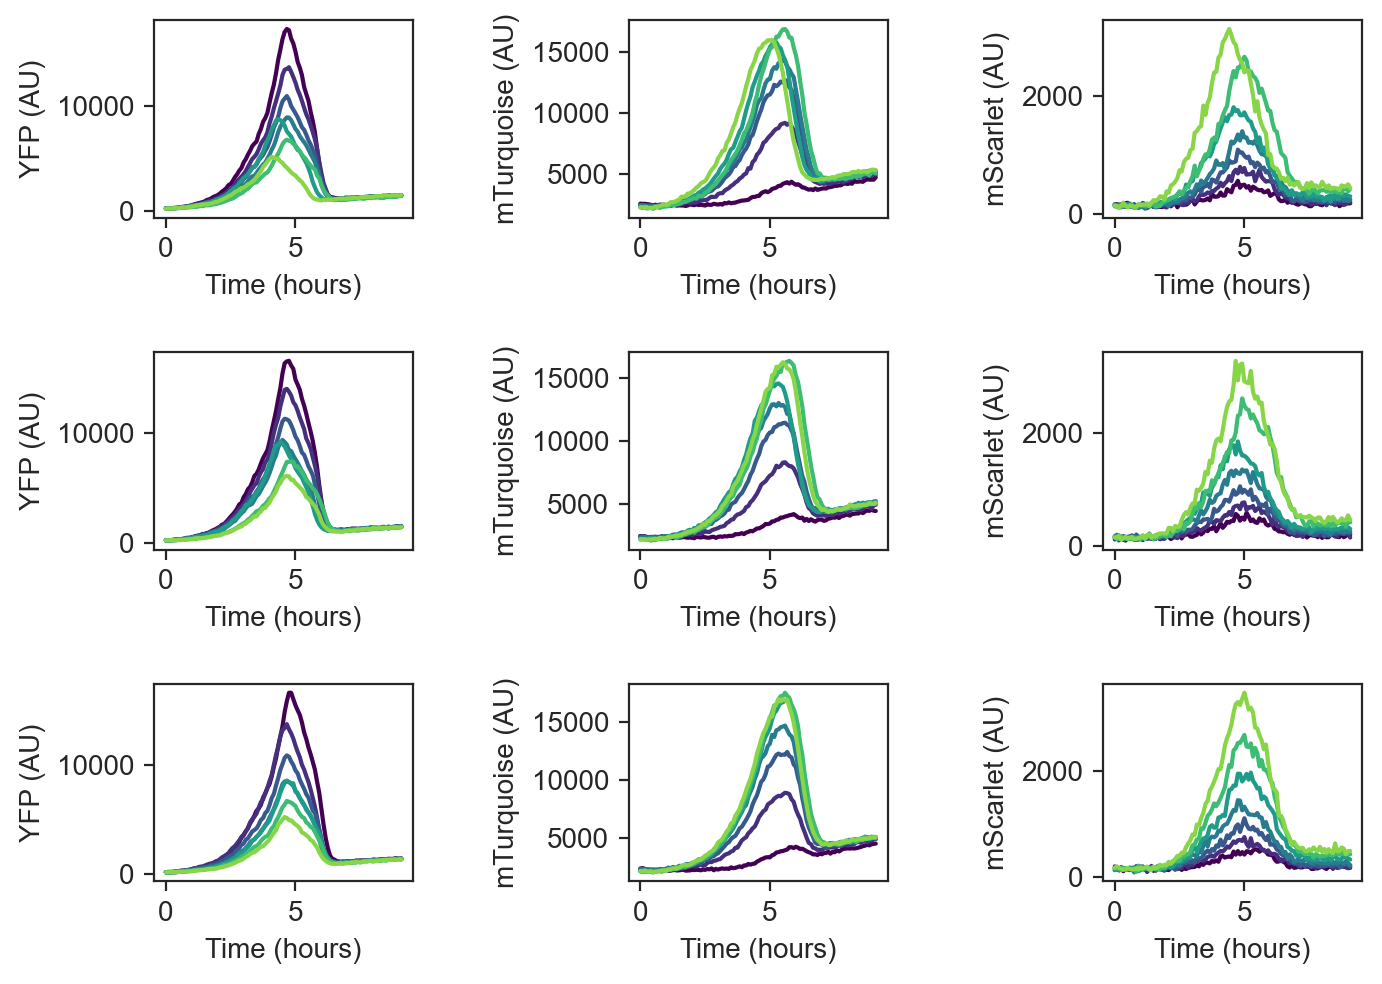

In [69]:
ts = np.arange(0,len(dics_list_b6[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[1]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b6):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

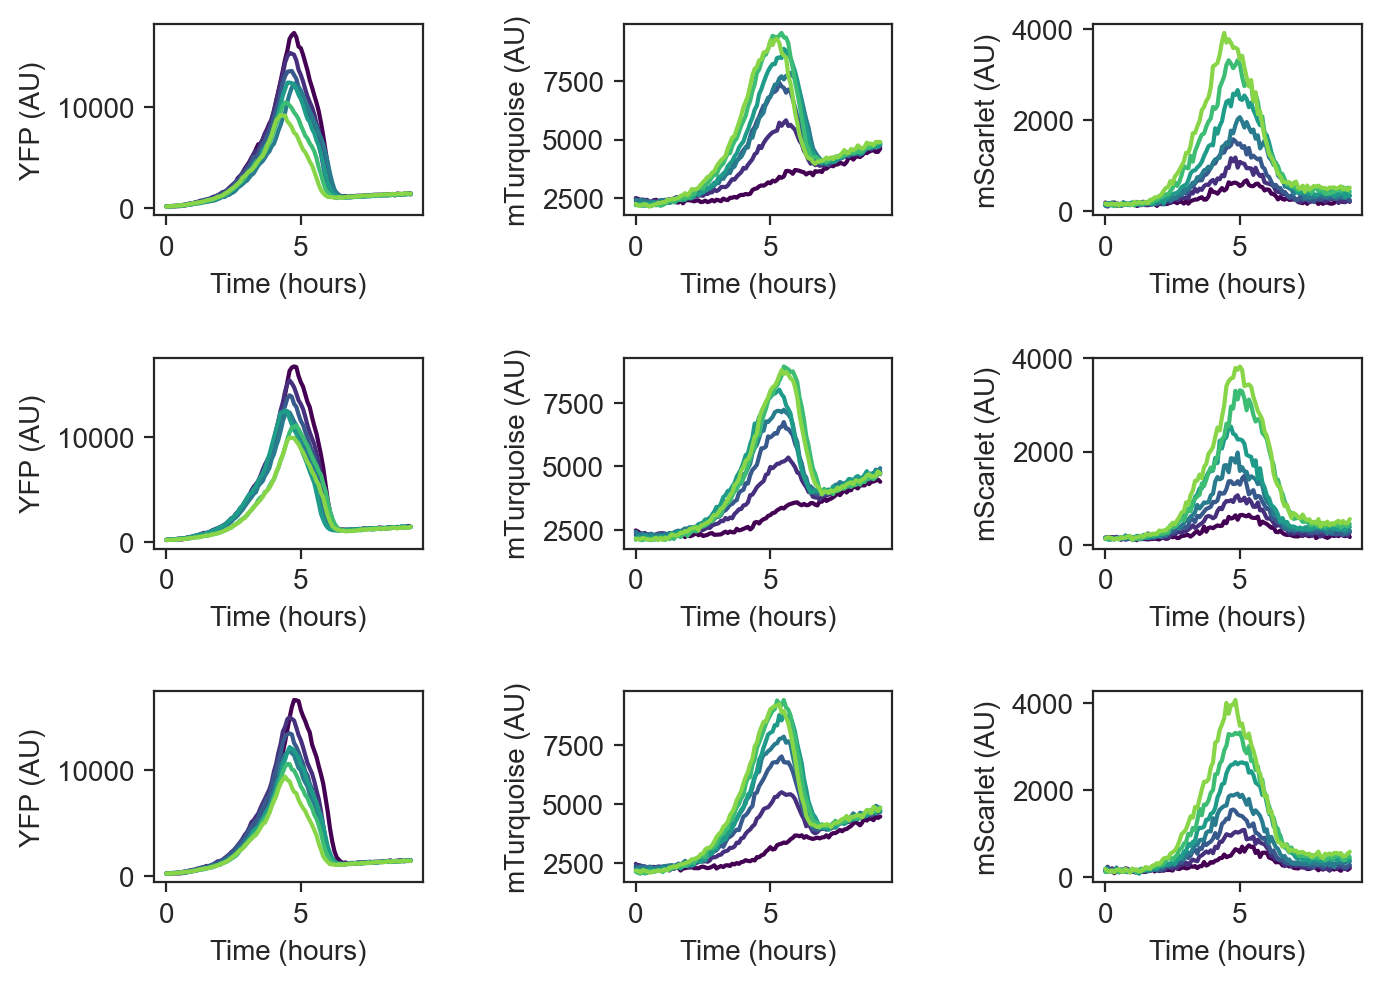

In [70]:
ts = np.arange(0,len(dics_list_b6[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[2]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b6):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

### Batch 7 (I,J)

In [71]:
rows = ['D','E',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]
wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B]

spl_names = ['Cond3_B7 R1','Cond3_B7 R2','Cond3_B7 R3',
             'Cond4_B7 R1','Cond4_B7 R2','Cond4_B7 R3',]


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B]


nts = 110
paths = ['3D_CT_Batch7_C1.xlsx','3D_CT_Batch7_C2.xlsx','3D_CT_Batch7_C3.xlsx','3D_CT_Batch7_C4.xlsx',
         '3D_CT_Batch7_C5.xlsx','3D_CT_Batch7_C6.xlsx','3D_CT_Batch7_C7.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b7 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b7.append(dic_pool)

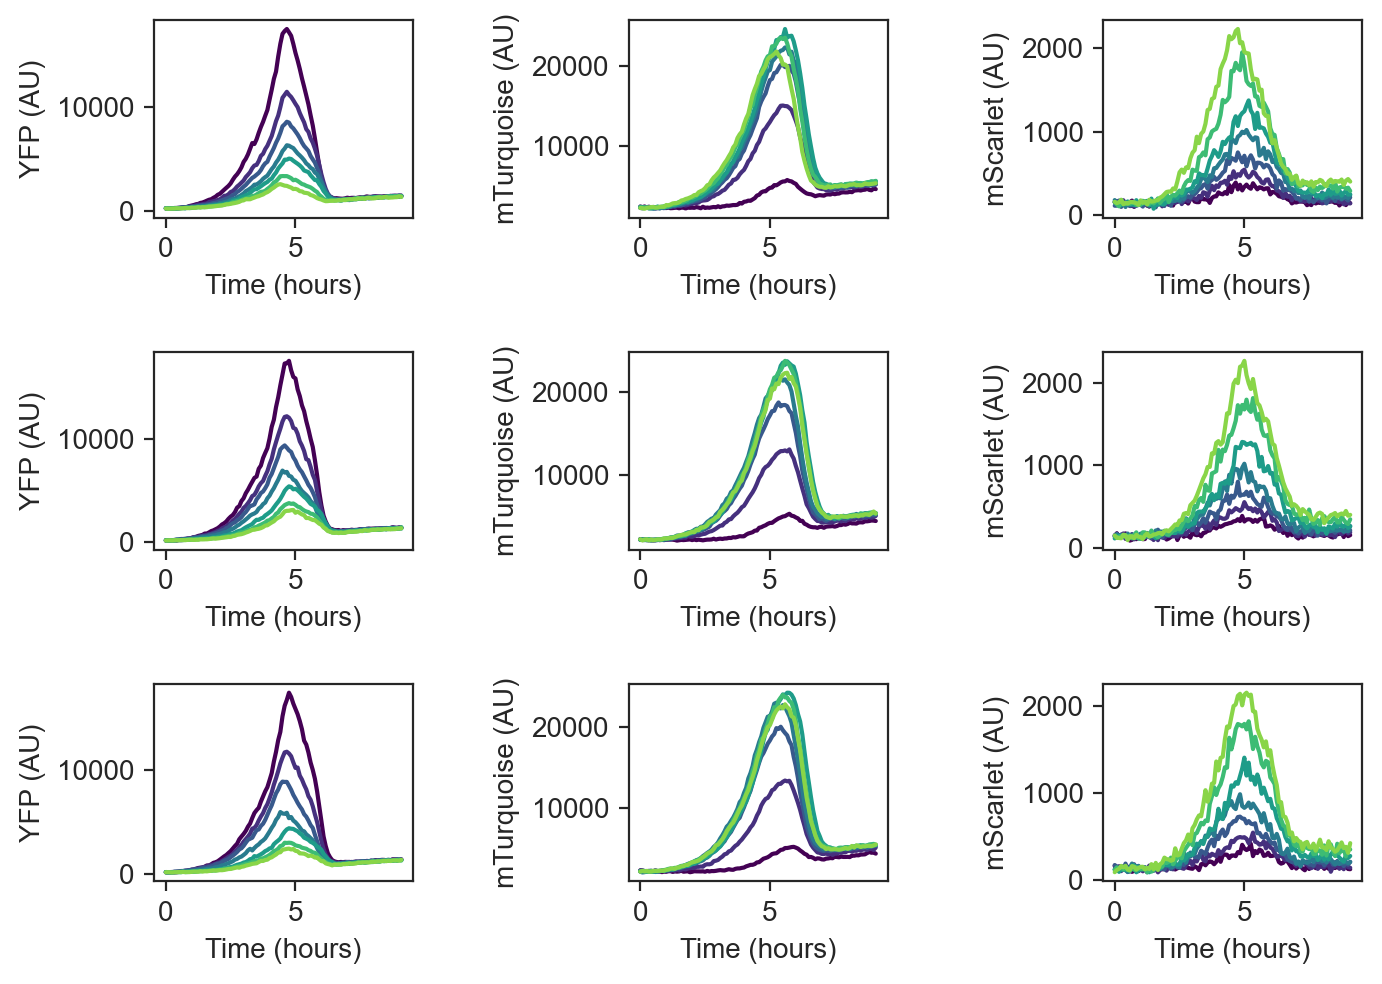

In [72]:
spl_idxs = [list(range(0,3)),list(range(3,6)),]
ts = np.arange(0,len(dics_list_b7[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b7):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

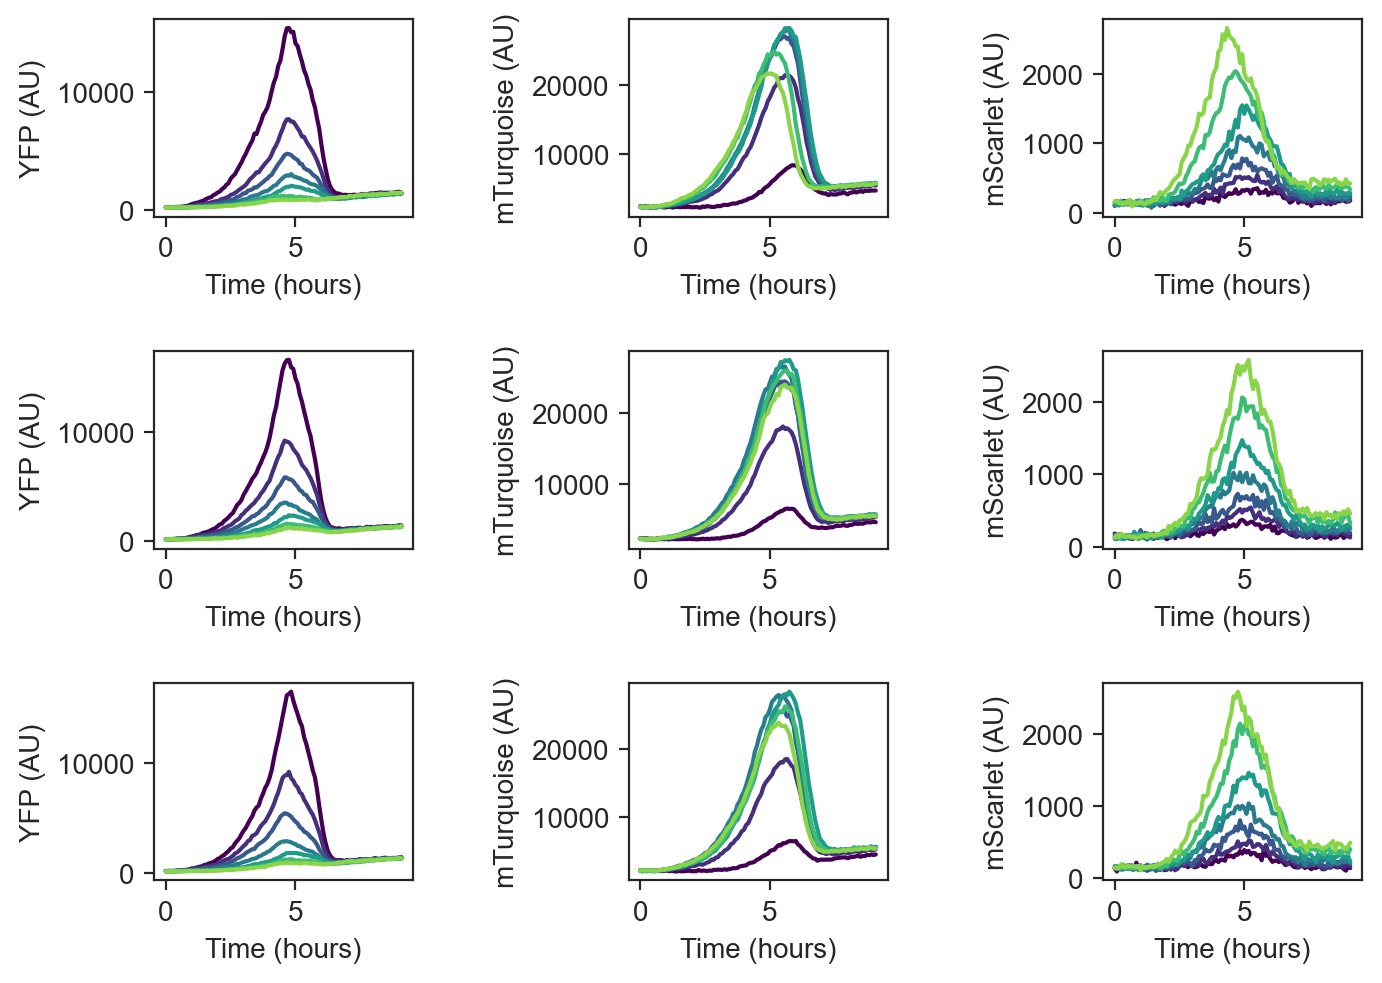

In [73]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[1]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b7):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

### Batch 10 (long-term stable)

In [74]:
rows = ['B','C','D','E','F','G',]
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B,wells_config_B,]

spl_names = ['Cond1_B10 R1','Cond1_B10 R2','Cond1_B10 R3',
             'Cond2_B10 R1','Cond2_B10 R2','Cond2_B10 R3',
             'Cond3_B10 R1','Cond3_B10 R2','Cond3_B10 R3',
             'Cond4_B10 R1','Cond4_B10 R2','Cond4_B10 R3',
             'Cond5_B10 R1','Cond5_B10 R2','Cond5_B10 R3',
             'Cond6_B10 R1','Cond6_B10 R2','Cond6_B10 R3',]

well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,]


nts = 110
paths = ['3D_CT_Batch10_C1.xlsx','3D_CT_Batch10_C2.xlsx','3D_CT_Batch10_C3.xlsx','3D_CT_Batch10_C4.xlsx',
         '3D_CT_Batch10_C5.xlsx','3D_CT_Batch10_C6.xlsx','3D_CT_Batch10_C7.xlsx','3D_CT_Batch10_C8.xlsx',
         '3D_CT_Batch10_C9.xlsx','3D_CT_Batch10_C10.xlsx',]

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_b10 = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_b10.append(dic_pool)

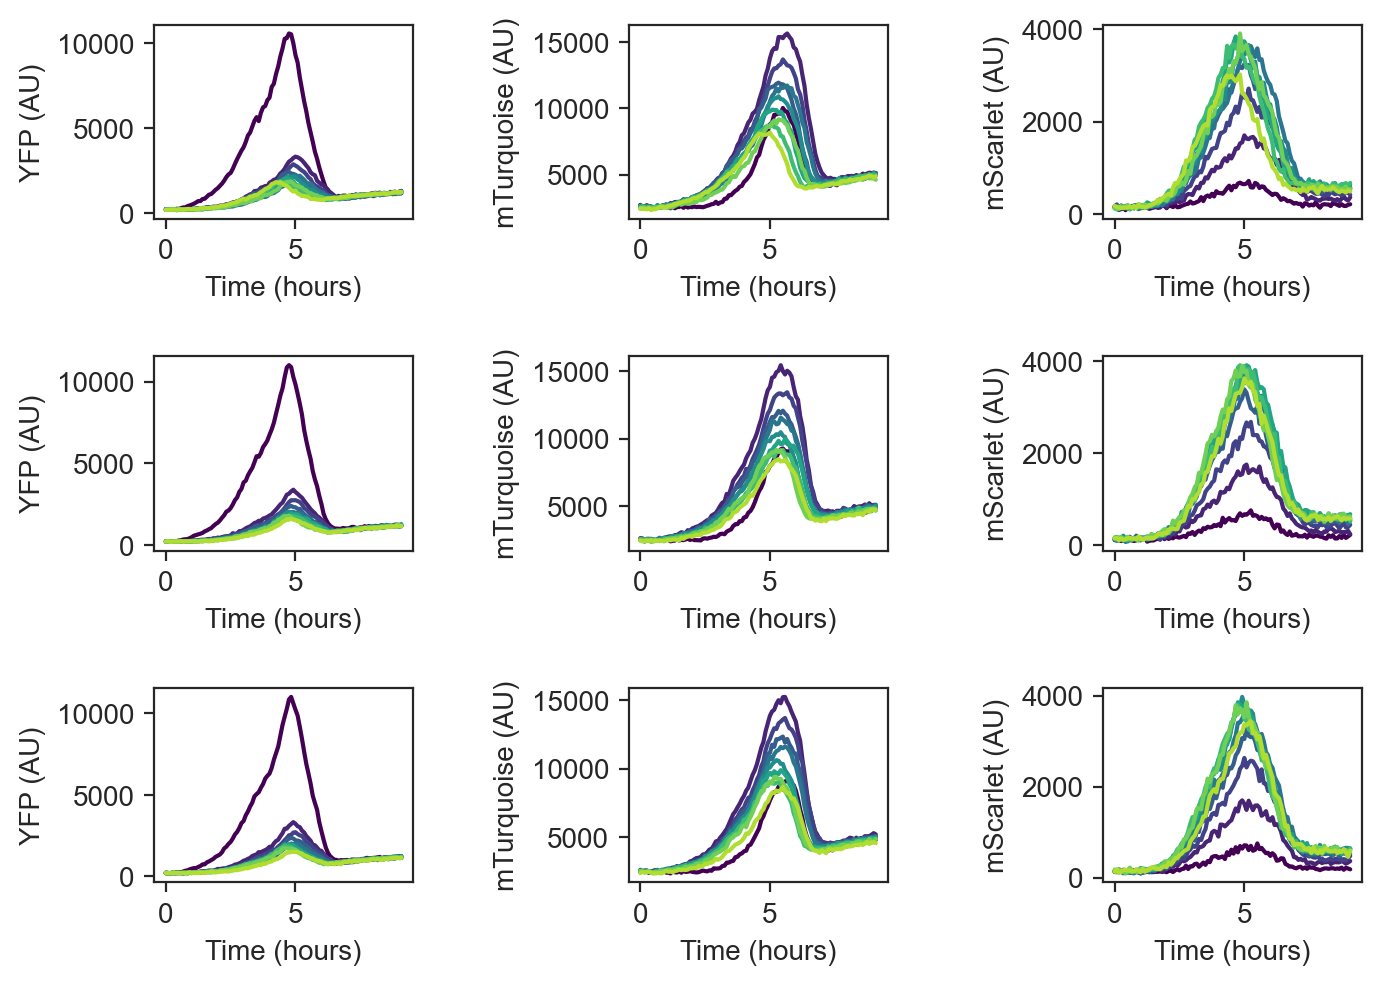

In [75]:
cmap = plt.cm.viridis
cs_long = [cmap(i) for i in range(0,cmap.N,25)]

spl_idxs = [list(range(15,18)),list(range(9,12)),]
ts = np.arange(0,len(dics_list_b10[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b10):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],c=cs_long[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

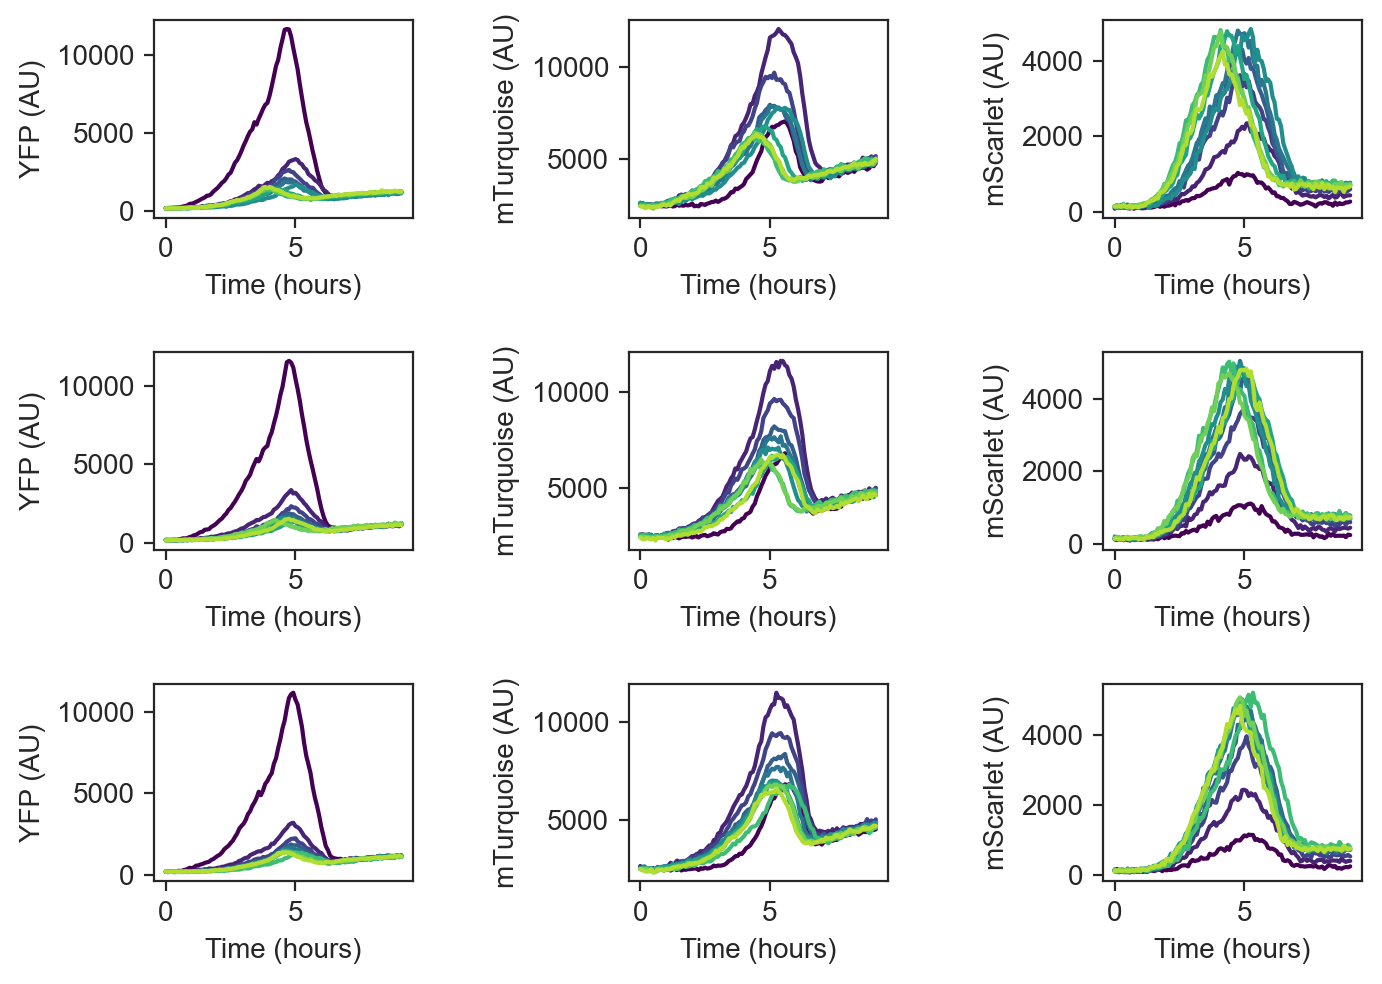

In [76]:
ts = np.arange(0,len(dics_list_b10[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[1]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_b10):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],c=cs_long[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

### Mixed uncontrolled culture

In [77]:
rows = ['E','F']
cols_A = ['2','3','4']
cols_B = ['6','7','8']

wells_config_A = [r+c for r,c in product(rows,cols_A)]
wells_config_B = [r+c for r,c in product(rows,cols_B)]

wells_configs = [wells_config_A,wells_config_A,wells_config_B,wells_config_B,
                 wells_config_A,wells_config_A,wells_config_B]

spl_names = ['YFP-mTurq R1','YFP-mTurq R2','YFP-mTurq R3',
             'YFP-mTurq-mScar R1','YFP-mTurq-mScar R2','YFP-mTurq-mScar R3']


well_to_name_A = dict(zip(wells_config_A,spl_names))
well_to_name_B = dict(zip(wells_config_B,spl_names))
map_list = [well_to_name_A,well_to_name_A,well_to_name_B,well_to_name_B,
            well_to_name_A,well_to_name_A,well_to_name_B,]


nts = 110
paths = ['3D_CT_Batchctrl_C1.xlsx','3D_CT_Batchctrl_C2.xlsx','3D_CT_Batchctrl_C3.xlsx','3D_CT_Batchctrl_C4.xlsx',
         '3D_CT_Batchctrl_C5.xlsx','3D_CT_Batchctrl_C6.xlsx','3D_CT_Batchctrl_C7.xlsx']

channels = [['OD700',70],['YFP',315],['mTuq',560],['mScarlet',805]]

dics_list_van = []
for k,path in enumerate(paths):
    df_full = retrieve_dfs("../Source_data/CC/"+path,channels,nts)
    trimmed,spl_list = retrieve_samples(df_full,wells_configs[k],multi=False)
    dic_pool = pool_trips(trimmed,spl_list,name_map=map_list[k],r_names=True,multi=False)
    dics_list_van.append(dic_pool)

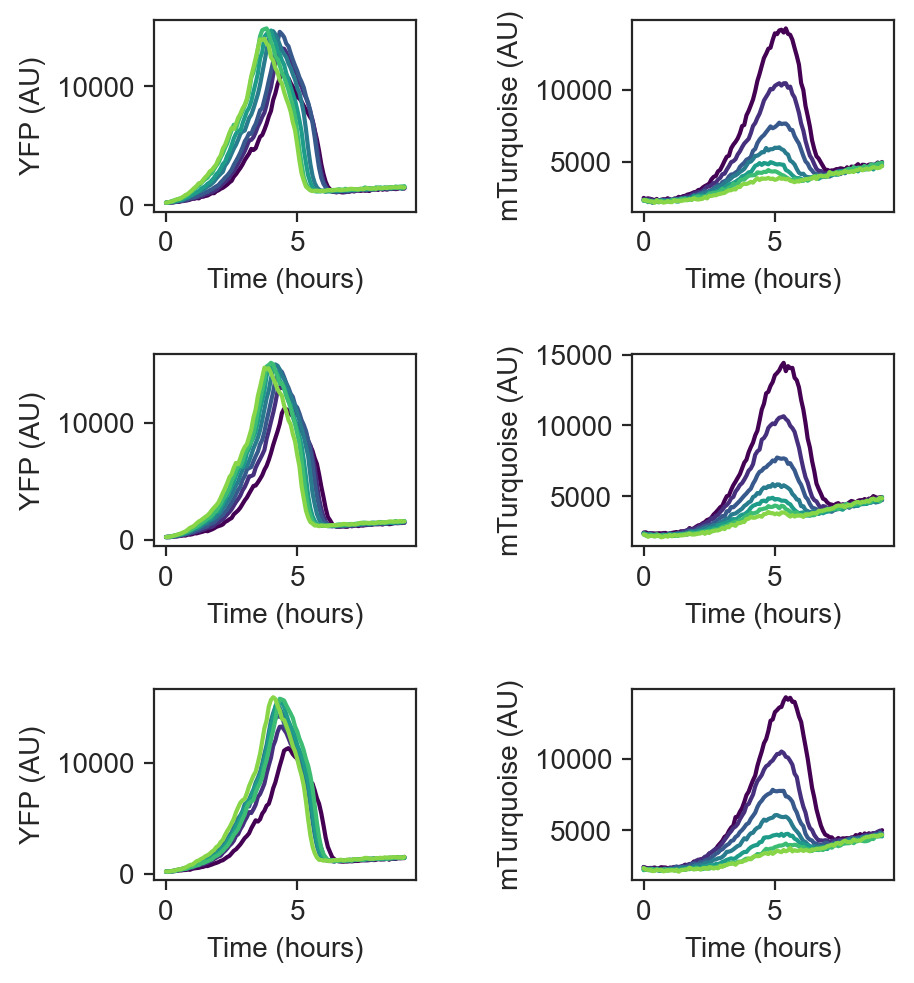

In [78]:
spl_idxs = [list(range(0,3)),list(range(3,6)),]
ts = np.arange(0,len(dics_list_van[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(4.66,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[0]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq',]):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_van):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[b,0].set_ylabel('YFP (AU)')
        ax[b,1].set_ylabel('mTurquoise (AU)')

plt.tight_layout(h_pad=2,w_pad=3)

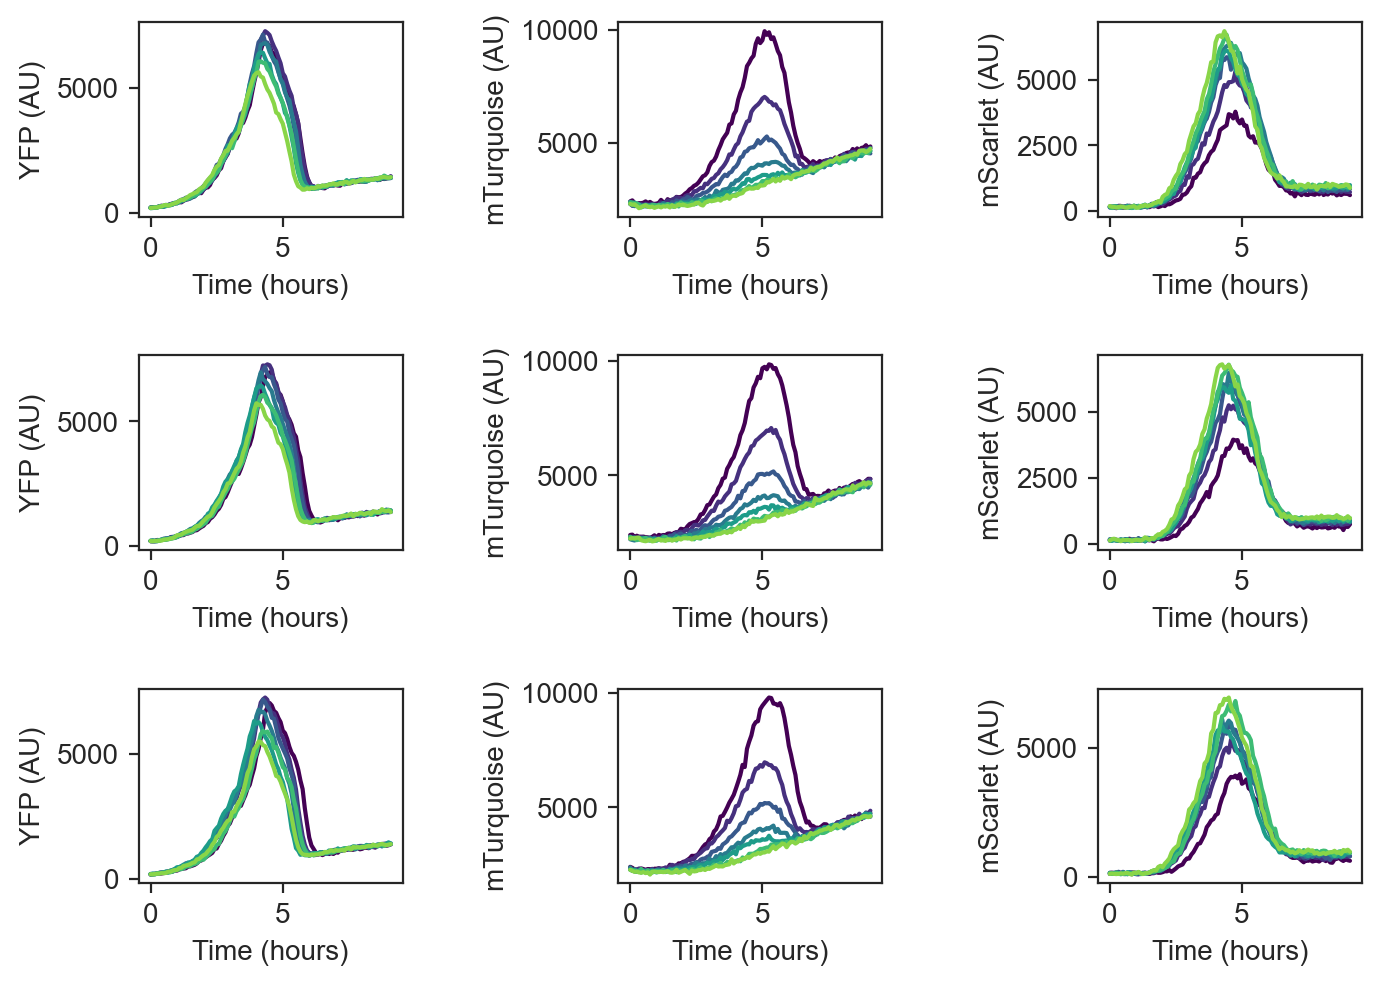

In [79]:
ts = np.arange(0,len(dics_list_van[0]['OD700']),1)*5/60
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(7,5))
    
    # for specific spl set
for b,k in enumerate(spl_idxs[1]):

    # for each channel                      
    for i,part in enumerate(['YFP','mTuq','mScarlet']):

        # for each cycle
        for l,dic_pool in enumerate(dics_list_van):
            ax[b,i].plot(ts,dic_pool[part][spl_names[k]],label=spl_names[k]+' C'+str(l+1),c=cs[l])
            ax[b,i].set_xlabel('Time (hours)')
            
        ax[i,0].set_ylabel('YFP (AU)')
        ax[i,1].set_ylabel('mTurquoise (AU)')
        ax[i,2].set_ylabel('mScarlet (AU)')

plt.tight_layout(h_pad=2,w_pad=3)